In [1]:
import os
import sys

import numpy as np
import scipy.io

import matplotlib.pyplot as plt
import pandas as pd

from preprocessing import *
from distributionFits import *

from scipy.stats import poisson
from scipy.stats import nbinom


In [2]:
def f(x):
    return int(x)
f2 = np.vectorize(f)

def sigAudFRCompareSpont(pattern, spont_win, windows, test='poisson', siglvl=0.001, minspike=10):
    
    if type(test) is str:
        test = [test]
    if type(siglvl) is float:
        siglvls = np.zeros(len(test))*siglvl
        siglvls = siglvls.tolist()
    if type(siglvl) is list:
        siglvls = siglvl
        
    assert len(test)==len(siglvls), 'Significance levels and number of testing distributions not equal'
    
    nNeu = len(pattern[0])
    nSeg = len(pattern[0][0])*len(pattern[0][0][0])*len(pattern[0][0][0][0])
    nWin = windows.shape[0]
    
    columns = []
    if nWin > 1:
        for w in np.arange(nWin):
            ave = 'avg window {0} - {1} ms'.format(windows[w,0], windows[w,1])
            var = 'var window {0} - {1} ms'.format(windows[w,0], windows[w,1])
            columns.extend([ave, var])
    else:
        ave = 'avg window {0} - {1} ms'.format(windows[0,0], windows[0,1])
        var = 'var window {0} - {1} ms'.format(windows[0,0], windows[0,1])
        columns.extend([ave, var])
    spave = 'avg window {0} - {1} ms'.format(spont_win[0], spont_win[1])
    spvar = 'var window {0} - {1} ms'.format(spont_win[0], spont_win[1])
    columns.extend([spave, spvar])

    activity_df = pd.DataFrame(columns=columns)

    pvals = np.zeros((nNeu, nWin))
    spont_fr = np.zeros(nNeu)
    dur = np.diff(spont_win)[0]
    spont_fr = PatternToCount(pattern=pattern, timerange=list(spont_win), timeBinSz=dur, vis=False)*1000/dur
    activity_df[spave] = np.mean(spont_fr, axis=(1,2,3,4))
    activity_df[spvar] = np.var(spont_fr, axis=(1,2,3,4))
    
    activ_fr = np.zeros((nNeu, nWin, 2))
    tested = False
    for w in np.arange(nWin):
        window = windows[w]
        ave = 'avg window {0} - {1} ms'.format(windows[w,0], windows[w,1])
        var = 'var window {0} - {1} ms'.format(windows[w,0], windows[w,1])
        dur = np.diff(window)
    
        fr = PatternToCount(pattern=pattern,timerange=list(window), timeBinSz=dur, vis=False)*1000/dur
        activity_df[ave] = np.mean(fr, axis=(1,2,3,4))
        activity_df[var] = np.var(fr, axis=(1,2,3,4))
        
        if 'poisson' in test:
            tested = True
            ind = test.index('poisson')
            pval = 'poisson pval compare win {0} - {1}'.format(str(w), nWin)
            activity_df[pval] = poisson.cdf(activity_df[ave]*dur*nSeg/1000, mu=activity_df[spave]*dur*nSeg/1000)
                        
            pospval = 1 - activity_df[pval]
            
            possig = pospval <= siglvls[ind] #positive significance
            negsig = activity_df[pval] <= siglvls[ind] #negative significance
            
            fr_limit = activity_df[ave]*dur/1000 >= minspike
#             possig[fr_limit] = False 
#             negsig[fr_limit] = False
            
            possig[activity_df[var]==0]=False
            negsig[activity_df[var]==0]=False

            print('Window {0}: Identified significant reposive neurons that {1} increased and {2} decreased firing rates out of {3} with {4} test.'.format(str(w), np.sum(possig), np.sum(negsig),len(possig), 'poisson'))
            pflag = 'poisson win {0} pos'.format(str(w))
            nflag = 'poisson win {0} neg'.format(str(w))
            activity_df[pflag] = possig
            activity_df[nflag] = negsig
        
        if 'quasipoisson' in test:
            tested = True
            ind = test.index('quasipoisson')
            pval = 'quasipoisson pval compare win {0} - {1}'.format(str(w), nWin)
            
            segdisper = activity_df[spave]/activity_df[spvar]
            
            activity_df[pval] = poisson.cdf(activity_df[ave]*dur*nSeg/1000/segdisper, mu=activity_df[spave]*dur*nSeg/1000/segdisper)
            
            pospval = 1 - activity_df[pval]
            
            possig = pospval <= siglvls[ind] #positive significance
            negsig = activity_df[pval] <= siglvls[ind] #negative significance
            
            fr_limit = activity_df[ave]*dur/1000 >= minspike
#             possig[fr_limit] = False 
#             negsig[fr_limit] = False
            
            possig[activity_df[var]==0]=False
            negsig[activity_df[var]==0]=False
            print('Window {0}: Identified significant reposive neurons that {1} increased and {2} decreased firing rates out of {3} with {4} test.'.format(str(w), np.sum(possig), np.sum(negsig),len(possig), 'quasipoisson'))
            pflag = 'quasipoisson win {0} pos'.format(str(w))
            nflag = 'quasipoisson win {0} neg'.format(str(w))
            activity_df[pflag] = possig
            activity_df[nflag] = negsig
        
        if 'nbinom' in test:
            tested = True
            ind = test.index('nbinom')
            pval = 'nbinom pval compare win {0} - {1}'.format(str(w), nWin)
            n = activity_df['avg window 700 - 1000 ms']**2 * dur*nSeg/1000/(activity_df['var window 700 - 1000 ms']-activity_df['avg window 700 - 1000 ms'])
            p = activity_df['avg window 700 - 1000 ms']/activity_df['var window 700 - 1000 ms']
            activity_df[pval] = nbinom.cdf(activity_df[ave]*dur*nSeg/1000, n, p)
            
            pospval = 1 - activity_df[pval]
            
            possig = pospval <= siglvls[ind] #positive significance
            negsig = activity_df[pval] <= siglvls[ind] #negative significance
            
            fr_limit = activity_df[ave]*dur/1000 >= minspike
#             possig[fr_limit] = False 
#             negsig[fr_limit] = False
            
            possig[activity_df[var]==0]=False
            negsig[activity_df[var]==0]=False
            print('Window {0}: Identified significant reposive neurons that {1} increased and {2} decreased firing rates out of {3} with {4} test.'.format(str(w), np.sum(possig), np.sum(negsig),len(possig), 'nbinom'))
            pflag = 'nbinom win {0} pos'.format(str(w))
            nflag = 'nbinom win {0} neg'.format(str(w))
            activity_df[pflag] = possig
            activity_df[nflag] = negsig
        
        assert tested, "Testing distribution not specified or unknown testing distribution.\n\
                           Possible tests: poisson, quasipoisson or nbinom"
            
    return activity_df



In [6]:
wd = '/media/feldheimlab/Seagate Expansion Drive/processedL5/2023-02-03-0/data001,data002,data003,data004,data005,data006,data007,data008,data009,data010,data011/'
# wd = '/Volumes/SYDNEYUSB/testfiles/2023-02-03-0/data001,data002,data003,data004,data005,data006,data007,data008,data009,data010,data011/'

asdf = scipy.io.loadmat(wd + 'asdf.mat')['asdf_raw']
IDs = scipy.io.loadmat(wd + 'asdf.mat')['IDs']
location = scipy.io.loadmat(wd + 'asdf.mat')['location']
basicinfo  = scipy.io.loadmat(wd + 'basicinfo.mat')
eisummary = scipy.io.loadmat(wd + 'eisummary.mat')
xy = scipy.io.loadmat(wd + 'xy.mat')
datasets = np.concatenate([[0],np.squeeze(scipy.io.loadmat(wd + 'segmentlengths.mat')['segmentseparations'])])
rise = np.squeeze(scipy.io.loadmat(wd + 'ttlTimes.mat')['ttlTimes'])

In [ ]:
stimdir = '/home/feldheimlab/python/Auditory/stimgen/muscimol/'
# stimdir = '/Users/ackmanadmin/Documents/python/Auditory/stimgen/muscimol/'

stim_dict = {'seg1':['fullfield.txt', 'kent'],
#            'seg2':'randchord.txt',
#             'seg3':'puretones.txt',
#             'seg4':'BLN_original.txt',
#             'seg5':'horizontal_pupcall_1_120rep.txt',
#             'seg6':'fullfield.txt',
#            'seg7':'randchord.txt',
#             'seg8':'puretones.txt',
#             'seg9':'BLN_original.txt',
#             'seg10':'horizontal_pupcall_1_120rep.txt'
            }

noi = 33 #test neuron

nNeu = asdf.shape[0]#n of neurons
timewindow = [0,1000] #pattern generation window

#determine auditory 
spont_win = [700,1000]
windows = np.array([[5,20]])#,[20,100],[105,120]])
testdist = ['poisson'] #['poisson','quasipoisson', 'nbinom']
siglvl = [0.001]#[0.001,0.001,0.05]
nWin = windows.shape[0] #n of windows
    
for key, value in stim_dict.items():
    
    print('New trial:', key, value)
    file = value[0]
    fit = value[1]
    seg = int(key[-1:])
    if len(key) > 4:
        seg = int(key[-2:])
        
    stims, num_stim, stim_ind = readStimFile(stimdir, file)

    if len(num_stim) != len(stim_ind):
        n_stim = 1
        for stim in num_stim:
            n_stim *= len(stim)
        print('Number of stimulations: ', n_stim)
        print(num_stim)
    else:
        print('Number of stimulations: ', len(num_stim))
        print(num_stim)

    print('\nStimulations order: ', stims.shape)
    print(stims)

    print('\nUnique indices: ', stim_ind.shape)
    print(stim_ind)
    
    #get the ttls of interest
    ttls = getTTLseg(seg=seg, ttls=rise, datasets=datasets)
    
    #get the pattern of this dataset
    pattern, ttlarray = patternGen(asdf, ttls, stims, num_stim, datasets[seg],  window=timewindow, force=True)
    
    print('\nNumber of windows assessed: ', windows.shape[0])
    #identify which cells are auditory responsive
    activity_df = sigAudFRCompareSpont(pattern=pattern, spont_win= spont_win, 
                                       windows=windows, test=testdist, 
                                       siglvl=siglvl, minspike=10)
    
    fit_data = np.array([[None] * nWin] * nNeu)

    auditory_responive = fit_data.copy()
    
    for w in range(nWin):
        auditory_responive[:,w] = (activity_df['poisson win {} neg'.format(str(w))] + activity_df['poisson win {} pos'.format(str(w))]).values.tolist()
    
        if fit == 'kent':
            print('Fitting kent distribution')
            elev = 90-np.array(num_stim[0]).astype(int)
            azim = -1*np.array(num_stim[1]).astype(int)
            azim = azim*np.pi/180
            elev = elev*np.pi/180
            print('\tCalculating counts for the window size')
            data = PatternToCount(pattern=pattern,timerange=list(windows[w]), timeBinSz=np.diff(windows[w]), vis=False)
            param_labels = ['kappa', 'beta', 'theta', 'phi', 'alpha', 'height', 'base']
            
            for n in range(nNeu):
                if n == 0:
                    print('\tDetermining x, y, z coordinates for the stimuli')
                    xs = azimElevCoord(azim, elev, data[n])
                    xyz = xs[:,:3]
                    print(xyz)
                                                                                                
                if activity[n,w]:
                    print('working on {}'.format(n))
                    p = fitKent(data[n].reshape(data.size), xyz)
                    fit_data[n,w] = p
        elif fit == 'gaussian':
            print('')
        elif fit == 'vonMises':
            print('')
        else: 
            print('')
        if fit == 'uniform':
            print('')
        else:
            print('')
    print(activity_df.columns)



New trial: seg1 ['fullfield.txt', 'kent']
Reading file: 
	 /home/feldheimlab/python/Auditory/stimgen/muscimol/fullfield.txt
Number of stimulations:  34
[['0', '40'], ['-144', '-126', '-108', '-90', '-72', '-54', '-36', '-18', '0', '18', '36', '54', '72', '90', '108', '126', '144']]

Stimulations order:  (30, 34)
[[11. 20. 25. ... 27.  3.  0.]
 [25. 17. 19. ... 13. 15.  8.]
 [22.  6. 28. ... 23. 13. 11.]
 ...
 [21. 17. 26. ...  7. 32. 23.]
 [ 7. 24. 18. ... 10.  8. 13.]
 [18.  9.  0. ... 30.  1. 13.]]

Unique indices:  (34,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33.]

Trials:  30 
Stimulations:  34
Nuerons: 199
TTLs found:  1020 
Presentations in stimfile:  1020
	Updated TTLs:  1020
shape:  199 2 17 30 2

Number of windows assessed:  1
Window 0: Identified significant reposive neurons that 49 increased and 13 decreased firing rates out of 199 with poisson test.


In [5]:
(activity_df['poisson win {} neg'.format(str(w))] + activity_df['poisson win {} pos'.format(str(w))]).values

array([False,  True, False, False,  True, False,  True,  True, False,
        True, False, False,  True, False, False, False,  True,  True,
       False, False, False, False, False,  True, False, False, False,
        True,  True, False,  True,  True,  True,  True, False,  True,
       False, False, False,  True, False, False, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True, False, False,
        True, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False,  True,  True, False,
        True, False,  True,  True, False, False, False, False, False,
       False, False,

ERROR! Session/line number was not unique in database. History logging moved to new session 358


In [ ]:
t = ['a', 'b', 'c']
t.index('c')

In [11]:
def sigAudFRCompareSpontFull(pattern, spont_win, windows, test='poisson', siglvl=0.001, fracthresh = .1, minspike=10):
    
    if type(test) is str:
        test = [test]
    if type(siglvl) is float:
        siglvls = np.zeros(len(test))*siglvl
        siglvls = siglvls.tolist()
    if type(siglvl) is list:
        siglvls = siglvl
    
    nNeu = len(pattern[0])
    nSeg = len(pattern[0][0])*len(pattern[0][0][0])*len(pattern[0][0][0][0])
    nTri = len(pattern[0][0][0][0])
    nWin = windows.shape[0]
    
    columns = []
    if nWin > 1:
        for w in np.arange(nWin):
            ave = 'avg window {0} - {1} ms'.format(windows[w,0], windows[w,1])
            var = 'var window {0} - {1} ms'.format(windows[w,0], windows[w,1])
            columns.extend([ave, var])
    else:
        ave = 'avg window {0} - {1} ms'.format(windows[0,0], windows[0,1])
        var = 'var window {0} - {1} ms'.format(windows[0,0], windows[0,1])
        columns.extend([ave, var])
    spave = 'avg window {0} - {1} ms'.format(spont_win[0], spont_win[1])
    spvar = 'var window {0} - {1} ms'.format(spont_win[0], spont_win[1])
    columns.extend([spave, spvar])

    activity_df = pd.DataFrame(columns=columns)

    pvals = np.zeros((nNeu, nWin))
    spont_fr = np.zeros(nNeu)
    dur2 = np.diff(spont_win)
    spont_fr = PatternToCount(pattern=pattern, timerange=list(spont_win), timeBinSz=dur2, vis=False)/dur2
    activity_df[spave] = np.mean(spont_fr, axis=(1,2,3,4))
    activity_df[spvar] = np.var(spont_fr, axis=(1,2,3,4))
    activ_fr = np.zeros((nNeu, nWin, 2))
    tested = False
    for w in np.arange(nWin):
        window = windows[w]

        ave = 'avg window {0} - {1} ms'.format(windows[w,0], windows[w,1])
        var = 'var window {0} - {1} ms'.format(windows[w,0], windows[w,1])
        dur = np.diff(window)[0]
        fr = PatternToCount(pattern=pattern,timerange=list(window), timeBinSz=dur, vis=False)
        activity_df[ave] = np.mean(fr, axis=(1,2,3,4))
        activity_df[var] = np.var(fr, axis=(1,2,3,4))
        activity = np.squeeze(fr)
        spave = 'sp avg window {0} - {1} ms'.format(windows[w,0], windows[w,1])
        spvar = 'sp var window {0} - {1} ms'.format(windows[w,0], windows[w,1])
        activity_df[spave] = np.mean(spont_fr*dur, axis=(1,2,3,4))
        activity_df[spvar] = np.var(spont_fr*dur, axis=(1,2,3,4))
        
        if 'poisson' in test:
            tested = True
            for neu in np.arange(nNeu):
                lamb = activity_df.loc[neu, spave]
                tes = activity[neu]

                col_abo_p = 'poisson {0} pos n loc above frac'.format(str(w))
                col_max_p = 'poisson {0} pos max frac'.format(str(w))
                col_abo_n = 'poisson {0} neg n loc above frac'.format(str(w))
                col_max_n = 'poisson {0} neg max frac'.format(str(w))
                
                if (activity_df.loc[neu, var]!=0)&(np.sum(tes) >= minspike):
                    p_full = poisson.cdf(tes, mu=lamb)
                    full_trials = 1 - p_full
                    pos_trials = np.sum(full_trials <= siglvl, axis=2)/nTri
                    neg_trials = np.sum(p_full <= siglvl, axis=2)/nTri
                    
                    if neu == noi:
                        print(neu, dur, dur2)

                        plt.imshow(pos_trials)
                        plt.colorbar()
                        plt.show()

                        plt.imshow(pos_trials>fracthresh)
                        plt.colorbar()
                        plt.show()
                        print(np.sum(pos_trials>fracthresh), np.max(pos_trials))
                    
                    activity_df.loc[neu, col_abo_p] = np.sum(pos_trials>fracthresh)
                    activity_df.loc[neu, col_max_p] = np.max(pos_trials)
                    activity_df.loc[neu, col_abo_n] = np.sum(neg_trials>fracthresh)
                    activity_df.loc[neu, col_max_n] = np.max(neg_trials)
                
                else:
                    activity_df.loc[neu, col_abo_p] = np.nan
                    activity_df.loc[neu, col_max_p] = np.nan
                    activity_df.loc[neu, col_abo_n] = np.nan
                    activity_df.loc[neu, col_max_n] = np.nan
            
            possig = ~np.isnan(activity_df[col_abo_p])
            negsig = ~np.isnan(activity_df[col_abo_n]) #negative significance
            
            possig[activity_df[col_abo_p]==0]=False
            negsig[activity_df[col_abo_n]==0]=False

            possig[activity_df[var]==0]=False

            print('Identified significant reposive neurons that {0} increased and {1} decreased firing rates out of {2} with {3} test.'.format(np.sum(possig), np.sum(negsig),len(possig), 'poisson'))
            pflag = 'poisson win {0} pos full'.format(str(w))
            nflag = 'poisson win {0} neg full'.format(str(w))
            activity_df[pflag] = possig
            activity_df[nflag] = negsig
            
        if 'quasipoisson' in test:
            tested = True
            segdisper = activity_df[spave]/activity_df[spvar]
            for neu in np.arange(nNeu):
                lamb = activity_df.loc[neu, spave]*dur/1000/segdisper[neu]
                tes = activity[neu]*dur/1000
                
                col_abo_p = 'quasipoisson {0} pos n loc above frac'.format(str(w))
                col_max_p = 'quasipoisson {0} pos max frac'.format(str(w))
                col_abo_n = 'quasipoisson {0} neg n loc above frac'.format(str(w))
                col_max_n = 'quasipoisson {0} neg max frac'.format(str(w))
                
                if (activity_df.loc[neu, var]!=0)&(np.sum(tes) >= minspike):
                    p_full = poisson.cdf(tes, mu=lamb)
                    full_trials = 1 - p_full
                    pos_trials = np.sum(full_trials <= siglvl, axis=2)/nTri
                    neg_trials = np.sum(p_full <= siglvl, axis=2)/nTri
                    
                    activity_df.loc[neu, col_abo_p] = np.sum(pos_trials>fracthresh)
                    activity_df.loc[neu, col_max_p] = np.max(pos_trials)
                    activity_df.loc[neu, col_abo_n] = np.sum(neg_trials>fracthresh)
                    activity_df.loc[neu, col_max_n] = np.max(neg_trials)
                
                else:
                    activity_df.loc[neu, col_abo_p] = np.nan
                    activity_df.loc[neu, col_max_p] = np.nan
                    activity_df.loc[neu, col_abo_n] = np.nan
                    activity_df.loc[neu, col_max_n] = np.nan
            
            possig = ~np.isnan(activity_df[col_abo_p])
            negsig = ~np.isnan(activity_df[col_abo_n]) #negative significance
            
            possig[activity_df[col_abo_p]==0]=False
            negsig[activity_df[col_abo_n]==0]=False

            possig[activity_df[var]==0]=False

            print('Identified significant reposive neurons that {0} increased and {1} decreased firing rates out of {2} with {3} test.'.format(np.sum(possig), np.sum(negsig),len(possig), 'quasipoisson'))
            pflag = 'quasipoisson win {0} pos full'.format(str(w))
            nflag = 'quasipoisson win {0} neg full'.format(str(w))
            activity_df[pflag] = possig
            activity_df[nflag] = negsig
                    
        if 'nbinom' in test:
            tested = True
            pval = 'nbinom pval compare win {0} - {1}'.format(str(w), nWin)
            for neu in np.arange(nNeu):
                tes = activity[neu]*dur/1000
                
                col_abo_p = 'nbinom {0} pos n loc above frac'.format(str(w))
                col_max_p = 'nbinom {0} pos max frac'.format(str(w))
                col_abo_n = 'nbinom {0} neg n loc above frac'.format(str(w))
                col_max_n = 'nbinom {0} neg max frac'.format(str(w))
                if (activity_df.loc[neu,spave]!= 0)|(activity_df.loc[neu,spvar]!= 0):
                    if (activity_df.loc[neu, var]!=0)&(np.sum(tes) >= minspike):
                        n = activity_df.loc[neu,spave]**2*dur/1000/(activity_df.loc[neu,spvar]-activity_df.loc[neu,spave])
                        p = activity_df.loc[neu,spave]/activity_df.loc[neu,spvar]
                        
                        p_full = nbinom.cdf(tes, n, p)
                        
                        full_trials = 1 - p_full
                        pos_trials = np.sum(full_trials <= siglvl, axis=2)/nTri
                        neg_trials = np.sum(p_full <= siglvl, axis=2)/nTri

                        if neu == noi:
                            print(p_full.shape)
                            print(neu)
                            plt.imshow(np.mean(tes, axis=2))
                            plt.colorbar()
                            plt.show()
                            print(n, p)
                            
                            plt.imshow(np.mean(p_full, axis=2))
                            plt.colorbar()
                            plt.show()
                            plt.imshow(np.var(p_full, axis=2))
                            plt.colorbar()
                            plt.show()
                            plt.imshow(pos_trials)
                            plt.colorbar()
                            plt.show()

                            plt.imshow(pos_trials>fracthresh)
                            plt.colorbar()
                            plt.show()
                            print(np.sum(pos_trials>fracthresh), np.max(pos_trials))
                        
                        
                        activity_df.loc[neu, col_abo_p] = np.sum(pos_trials>=fracthresh)
                        activity_df.loc[neu, col_max_p] = np.max(pos_trials)
                        activity_df.loc[neu, col_abo_n] = np.sum(neg_trials>=fracthresh)
                        activity_df.loc[neu, col_max_n] = np.max(neg_trials)

                    else:
                        activity_df.loc[neu, col_abo_p] = np.nan
                        activity_df.loc[neu, col_max_p] = np.nan
                        activity_df.loc[neu, col_abo_n] = np.nan
                        activity_df.loc[neu, col_max_n] = np.nan
                else:
                    activity_df.loc[neu, col_abo_p] = np.nan
                    activity_df.loc[neu, col_max_p] = np.nan
                    activity_df.loc[neu, col_abo_n] = np.nan
                    activity_df.loc[neu, col_max_n] = np.nan
            possig = ~np.isnan(activity_df[col_abo_p])
            negsig = ~np.isnan(activity_df[col_abo_n]) #negative significance
            
            possig[activity_df[col_abo_p]==0]=False
            negsig[activity_df[col_abo_n]==0]=False
            
            possig[activity_df[var]==0]=False

            print('Identified significant reposive neurons that {0} increased and {1} decreased firing rates out of {2} with {3} test.'.format(np.sum(possig), np.sum(negsig),len(possig), 'nbinom'))
            pflag = 'nbinom win {0} pos full'.format(str(w))
            nflag = 'nbinom win {0} neg full'.format(str(w))
            activity_df[pflag] = possig
            activity_df[nflag] = negsig
        
        assert tested, "Testing distribution not specified or unknown testing distribution.\n\
                           Possible tests: poisson, quasipoisson or nbinom"
            
    return activity_df


windows=np.array([[5,20]])#,[20,100],[105,120]])

activity_df = sigAudFRCompareSpont(pattern=pattern, spont_win=[700,1000], 
                                   windows=windows, test=['poisson','quasipoisson', 'nbinom'], 
                                   siglvl=[0.001,0.001,0.05], 
                                   minspike=10)

# activity_df2 = sigAudFRCompareSpontFull(pattern=pattern, spont_win=[700,1000], 
#                                    windows=windows, test=['poisson'], siglvl=0.01,
#                                    fracthresh = .1, minspike=10)

# activity_df[activity_df2.columns] = activity_df2.values


Window 0: Identified significant reposive neurons that 49 increased and 13 decreased firing rates out of 199 with poisson test.
Window 0: Identified significant reposive neurons that 65 increased and 19 decreased firing rates out of 199 with quasipoisson test.
Window 0: Identified significant reposive neurons that 47 increased and 12 decreased firing rates out of 199 with nbinom test.


In [ ]:
activity_df2.columns

In [12]:
# bins = np.arange(0,30,0.5)
bins = np.arange(0,5,0.05)

valid = activity_df['var window 700 - 1000 ms']!=0
valid = activity_df['avg window 700 - 1000 ms']!=0

print(np.mean((activity_df.loc[valid,'avg window 700 - 1000 ms']*300/15/activity_df2.loc[valid,'sp avg window 5 - 20 ms'])))
plt.scatter(np.where(valid)[0], activity_df.loc[valid,'avg window 700 - 1000 ms']*300/15/activity_df2.loc[valid,'sp avg window 5 - 20 ms'])
plt.show()


print(np.mean((activity_df.loc[valid,'var window 700 - 1000 ms']*300/15)/activity_df2.loc[valid,'sp var window 5 - 20 ms']))
plt.scatter(np.where(valid)[0], (activity_df.loc[valid,'var window 700 - 1000 ms']*300/15)/activity_df2.loc[valid,'sp var window 5 - 20 ms'])
plt.show()

plt.hist(activity_df2.loc[valid,'sp var window 5 - 20 ms']/activity_df2.loc[valid,'sp avg window 5 - 20 ms'],
         bins=bins)
plt.hist(activity_df.loc[valid,'var window 700 - 1000 ms']/activity_df.loc[valid, 'avg window 700 - 1000 ms'], 
         bins=bins)

plt.show()


NameError: name 'activity_df2' is not defined

In [ ]:
n = 0.25164
p = 0.08681124700542175
interp = np.arange(-1,500)/20
print(n, p)

plt.plot(interp, nbinom.cdf(interp, n, p))
plt.show()


[ 2. 17. 30.]


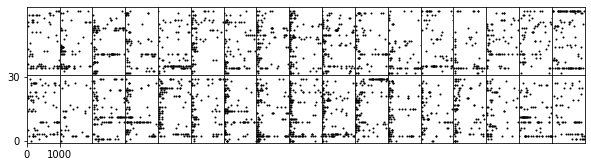

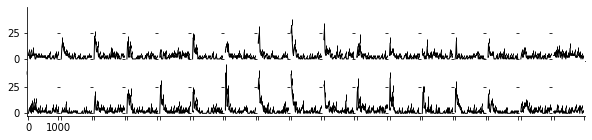

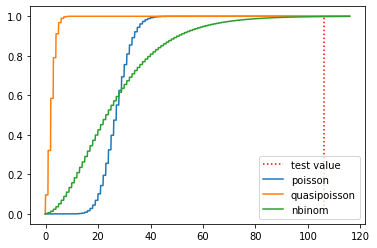

In [14]:
PatternRaster3d(pattern3d=pattern[0][noi], timerange=timewindow)

timeBinSz = 20
fr = PatternToCount(pattern=pattern, timeBinSz=timeBinSz, timerange=timewindow, vis=False)

nmean = np.squeeze(np.mean(fr[noi]*1000/timeBinSz, axis = 2))
nsem = np.squeeze(np.std(fr[noi]*1000/timeBinSz, axis = 2))/np.sqrt(30)

fig, axs = plt.subplots(fr.shape[1], fr.shape[2], figsize =(10,2), sharey=True)

xs = np.arange(fr.shape[-1])
if fr.shape[1]==1:
    for i in range(fr.shape[2]):
        axs[i].errorbar(xs, nmean[i], yerr=[np.zeros_like(nsem[i]), nsem[i]], color='k', linewidth=1)
        if i != 0:
            axs[i].set_xticklabels([])
            axs[i].spines[['left','right', 'top']].set_visible(False)
        else:
            axs[i].spines[['right', 'top']].set_visible(False)
    axs[0].set_xticks([xs[0], xs[-1]])
    axs[0].set_xticklabels(timewindow)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()    
else:
    for j in range(fr.shape[1]):
        for i in range(fr.shape[2]):
            axs[j][i].errorbar(xs, nmean[j][i], yerr=[np.zeros_like(nsem[j][i]), nsem[j][i]], color='k', linewidth=1)
            if i != 0:
                axs[j][i].set_xticklabels([])
                axs[j][i].spines[['left','right', 'top']].set_visible(False)
            else:
                axs[j][i].spines[['right', 'top']].set_visible(False)
    axs[fr.shape[1]-1][0].set_xticks([xs[0], xs[-1]])
    axs[fr.shape[1]-1][0].set_xticklabels(timewindow)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    
dur = 15
nSeg = 1020

t = activity_df.loc[noi, 'avg window 5 - 20 ms']*dur*nSeg/1000
plt.vlines(t,0,1, color='r', linestyle=':', label='test value')

interp = np.arange(-1,t*10+100)/10

lamb = activity_df.loc[noi, 'avg window 700 - 1000 ms']*dur*nSeg/1000
plt.plot(interp, poisson.cdf(interp, mu=lamb), label='poisson')

segdisper = activity_df.loc[noi, 'var window 700 - 1000 ms']/activity_df.loc[noi, 'avg window 700 - 1000 ms']
lamb = activity_df.loc[noi, 'avg window 700 - 1000 ms']/segdisper*dur*nSeg/1000
plt.plot(interp, poisson.cdf(interp, mu=lamb), label='quasipoisson')

n = activity_df.loc[noi, 'avg window 700 - 1000 ms']**2*dur*nSeg/1000/(activity_df.loc[noi, 'var window 700 - 1000 ms']-activity_df.loc[noi, 'avg window 700 - 1000 ms'])
p = activity_df.loc[noi, 'avg window 700 - 1000 ms']/activity_df.loc[noi, 'var window 700 - 1000 ms']
plt.plot(interp, nbinom.cdf(interp, n, p), label='nbinom')

# activity_df.iloc[noi]

plt.legend()
plt.show()

# dur = 15
# nSeg = 1

# t = activity_df2.loc[noi, 'avg window 5 - 20 ms']*nSeg
# lamb = activity_df2.loc[noi, 'sp avg window 5 - 20 ms']*nSeg

# interp = np.arange(-1,t*10+20)/10

# plt.vlines(t,0,1, color='r', linestyle=':', label='test value')
# # plt.plot(interp, poisson.cdf(interp, mu=lamb), label='poisson')
# # print(lamb)
# # segdisper = activity_df2.loc[noi, 'sp var window 5 - 20 ms']/activity_df2.loc[noi, 'sp avg window 5 - 20 ms']
# # lamb /= segdisper
# # print(segdisper, lamb)
# # plt.plot(interp, poisson.cdf(interp, mu=lamb), label='quasipoisson')

# n = activity_df2.loc[noi, 'sp avg window 5 - 20 ms']**2/(activity_df2.loc[noi, 'sp var window 5 - 20 ms']-activity_df2.loc[noi, 'sp avg window 5 - 20 ms'])
# p = activity_df2.loc[noi, 'sp avg window 5 - 20 ms']/activity_df2.loc[noi, 'sp var window 5 - 20 ms']
# print(n, p)
# plt.plot(interp, nbinom.cdf(interp, n, p), label='nbinom')

# plt.legend()
# plt.show()




In [22]:
nbin = np.sum(activity_df['nbinom win 0 pos'])
nqpois = np.sum(activity_df['quasipoisson win 0 pos'])
npois = np.sum(activity_df['poisson win 0 pos'])
print('Poission auditory pos responsive: ', npois,\
      '\nQuasipoission auditory pos responsive: ', nqpois,\
      '\nNeg binomial auditory pos responsive: ', nbin)

nbin = np.sum(activity_df['nbinom win 0 neg'])
nqpois = np.sum(activity_df['quasipoisson win 0 neg'])
npois = np.sum(activity_df['poisson win 0 neg'])

print('\nPoission auditory neg responsive: ', npois,\
      '\nQuasipoission auditory neg responsive: ', nqpois,\
      '\nNeg binomial auditory neg responsive: ', nbin)

compare = f2(np.array(activity_df['poisson win 0 pos'].values)) + \
          f2(np.array(activity_df['quasipoisson win 0 pos'].values)) + \
          f2(np.array(activity_df['nbinom win 0 pos'].values))
compare2 = f2(np.array(activity_df['poisson win 0 neg'].values)) + \
          f2(np.array(activity_df['quasipoisson win 0 neg'].values)) + \
          f2(np.array(activity_df['nbinom win 0 neg'].values))

print('\nAll three distributions not positive : ', np.sum(compare==0))
print('Only one distributions found positive : ',np.sum(compare==1))
print('Only two distributions found positive : ',np.sum(compare==2))
print('All three distributions found positive : ',np.sum(compare==3))

print('\nAll three distributions not negative : ',np.sum(compare2==0))
print('Only one distributions found negative : ',np.sum(compare2==1))
print('Only two distributions found negative : ',np.sum(compare2==2))
print('All three distributions found negative : ',np.sum(compare2==3))

Poission auditory pos responsive:  49 
Quasipoission auditory pos responsive:  65 
Neg binomial auditory pos responsive:  47

Poission auditory neg responsive:  13 
Quasipoission auditory neg responsive:  19 
Neg binomial auditory neg responsive:  12

All three distributions not positive :  127
Only one distributions found positive :  19
Only two distributions found positive :  17
All three distributions found positive :  36

All three distributions not negative :  180
Only one distributions found negative :  5
Only two distributions found negative :  3
All three distributions found negative :  11


In [27]:
nbin = np.sum(activity_df['nbinom win 0 pos'])
npois = np.sum(activity_df['poisson win 0 pos'])
print('Poission auditory pos responsive: ', npois,\
      '\nNeg binomial auditory pos responsive: ', nbin)

nbin = np.sum(activity_df['nbinom win 0 neg'])
npois = np.sum(activity_df['poisson win 0 neg'])

print('\nPoission auditory neg responsive: ', npois,\
      '\nNeg binomial auditory neg responsive: ', nbin)

compare = f2(np.array(activity_df['poisson win 0 pos'].values)) + \
          f2(np.array(activity_df['nbinom win 0 pos'].values))
compare2 = f2(np.array(activity_df['poisson win 0 neg'].values)) + \
          f2(np.array(activity_df['nbinom win 0 neg'].values))

print('\nAll three distributions not positive : ', np.sum(compare==0))
print('Only one distributions found positive : ',np.sum(compare==1))
print('Both distributions found positive : ',np.sum(compare==2))

print('\nAll three distributions not negative : ',np.sum(compare2==0))
print('Only one distributions found negative : ',np.sum(compare2==1))
print('Both distributions found negative : ',np.sum(compare2==2))

Poission auditory pos responsive:  49 
Neg binomial auditory pos responsive:  47

Poission auditory neg responsive:  13 
Neg binomial auditory neg responsive:  12

All three distributions not positive :  139
Only one distributions found positive :  24
Both distributions found positive :  36

All three distributions not negative :  185
Only one distributions found negative :  3
Both distributions found negative :  11


[ 2. 17. 30.]


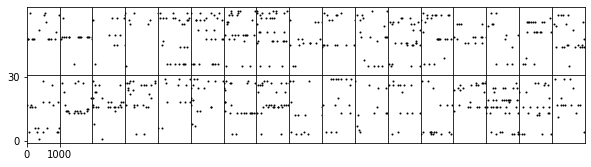

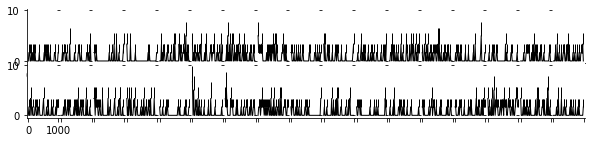

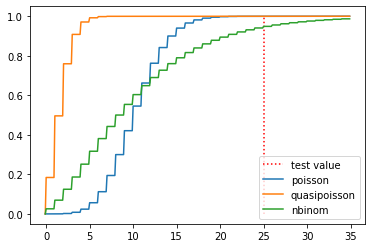

[ 2. 17. 30.]


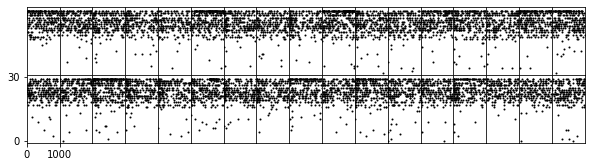

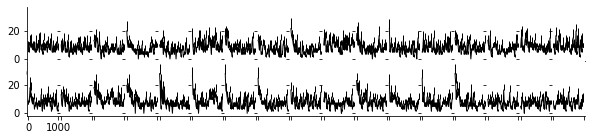

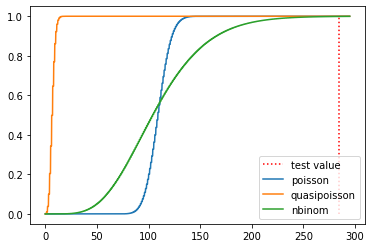

[ 2. 17. 30.]


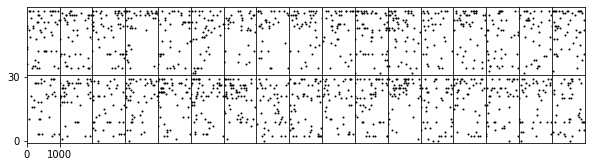

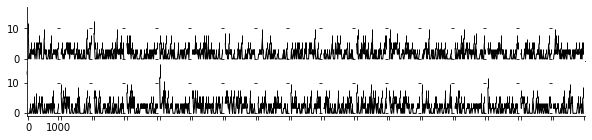

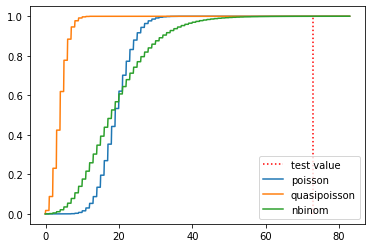

[ 2. 17. 30.]


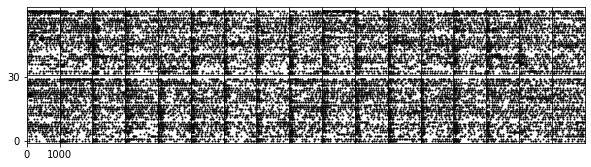

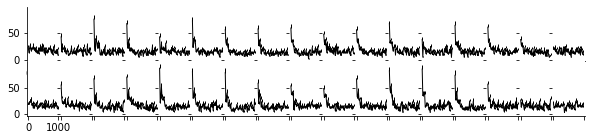

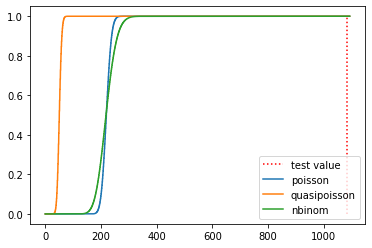

[ 2. 17. 30.]


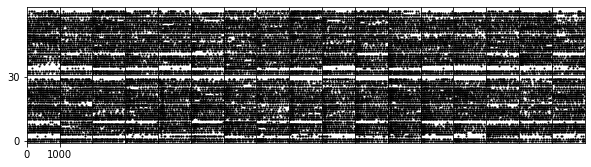

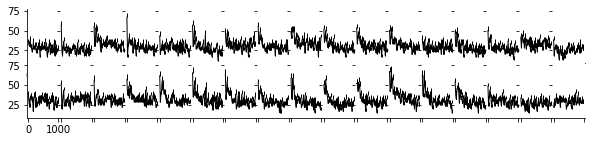

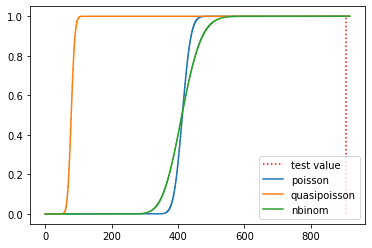

[ 2. 17. 30.]


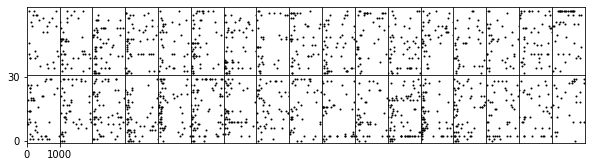

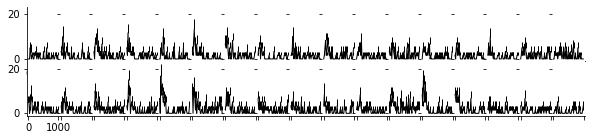

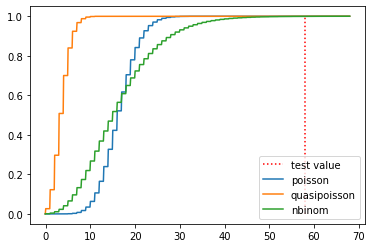

[ 2. 17. 30.]


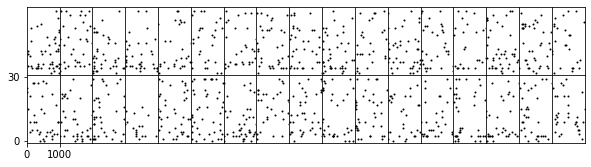

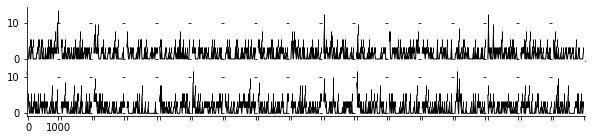

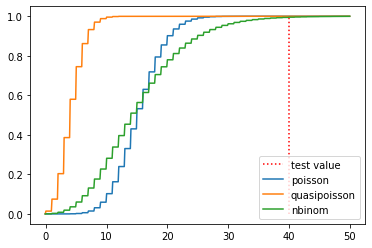

[ 2. 17. 30.]


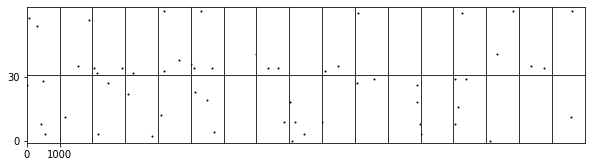

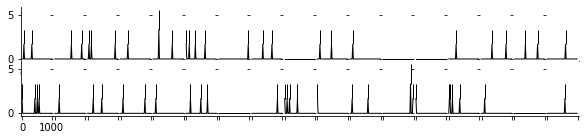

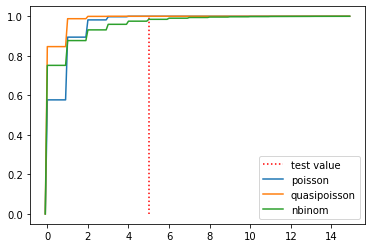

[ 2. 17. 30.]


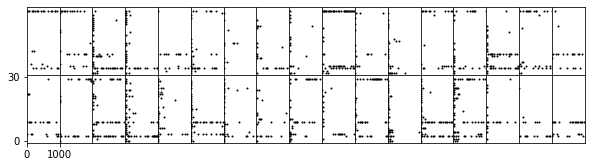

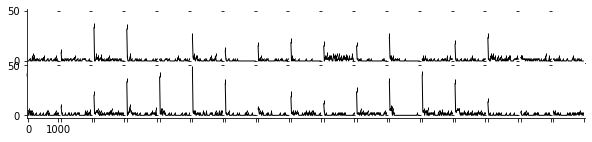

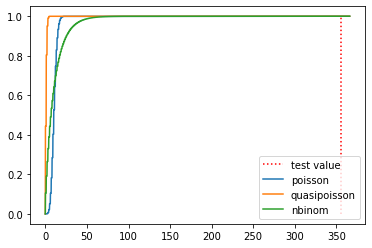

[ 2. 17. 30.]


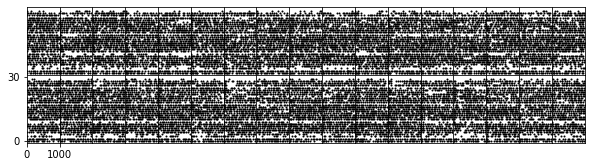

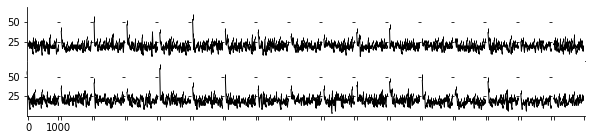

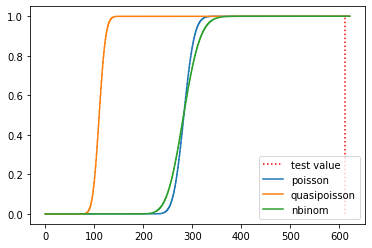

[ 2. 17. 30.]


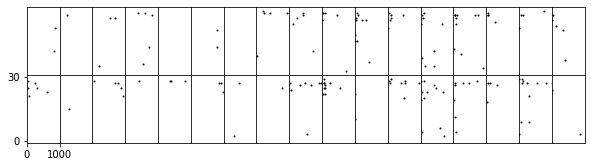

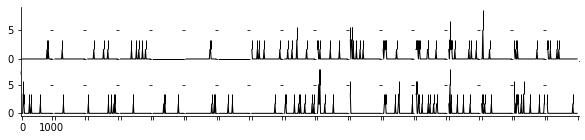

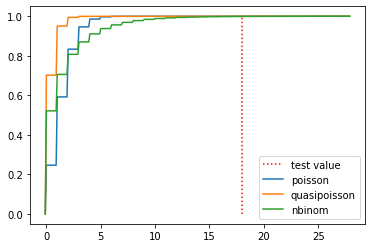

[ 2. 17. 30.]


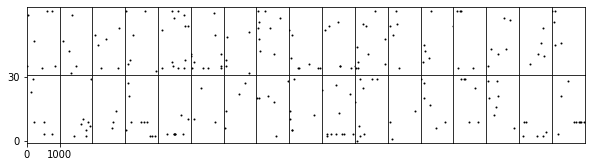

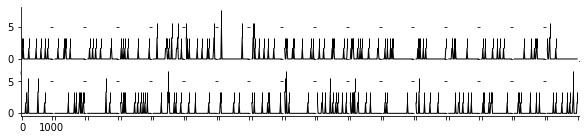

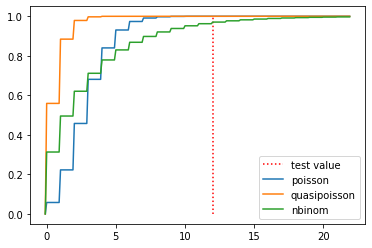

[ 2. 17. 30.]


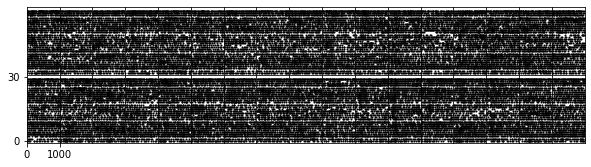

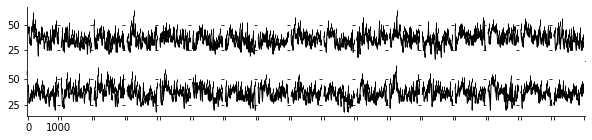

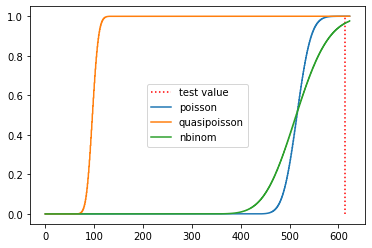

[ 2. 17. 30.]


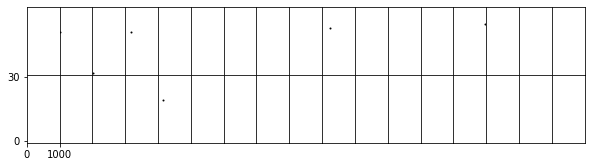

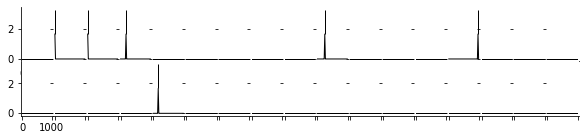

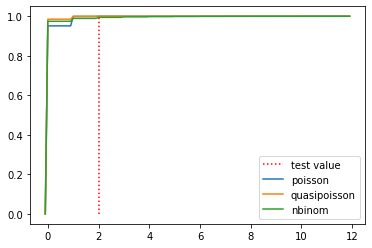

[ 2. 17. 30.]


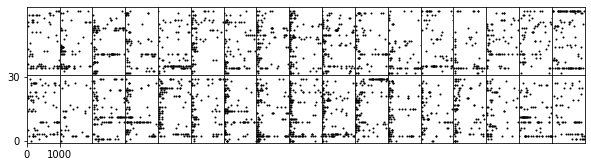

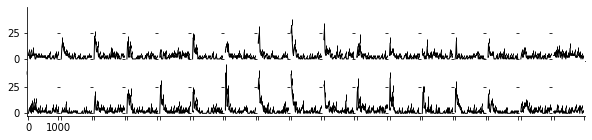

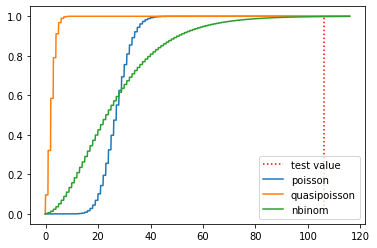

[ 2. 17. 30.]


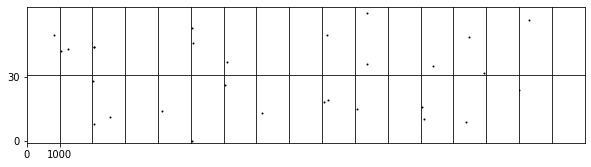

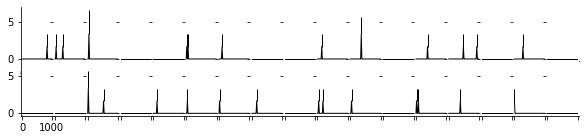

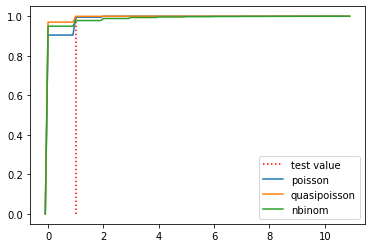

[ 2. 17. 30.]


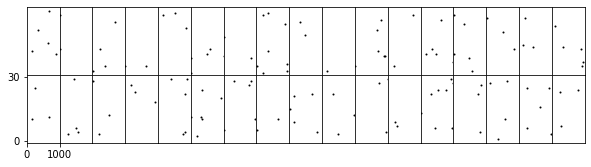

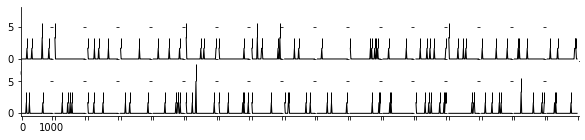

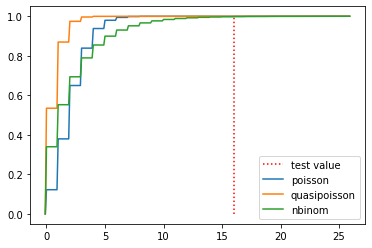

[ 2. 17. 30.]


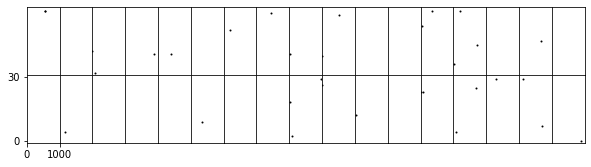

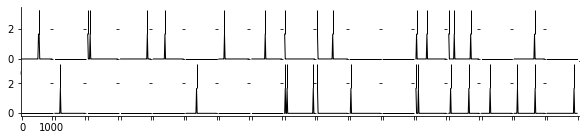

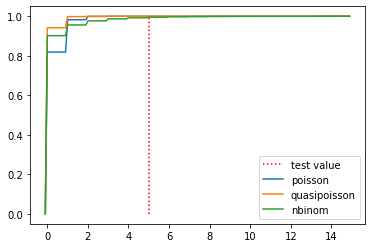

[ 2. 17. 30.]


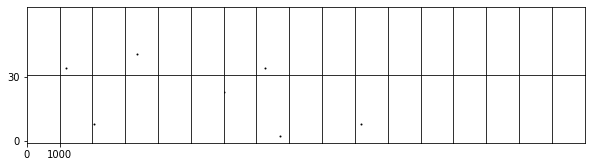

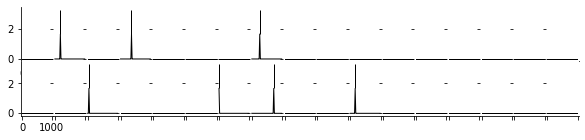

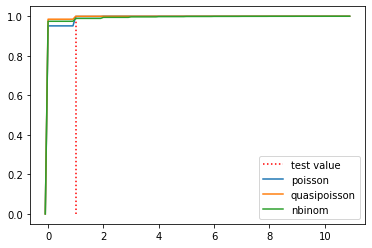

[ 2. 17. 30.]


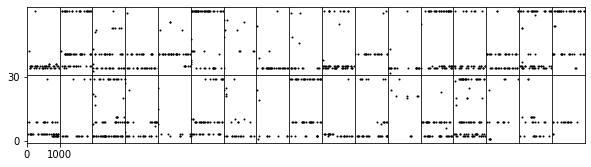

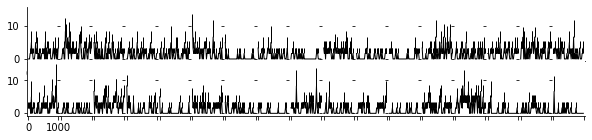

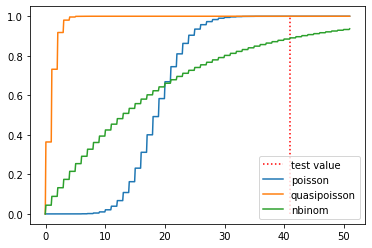

[ 2. 17. 30.]


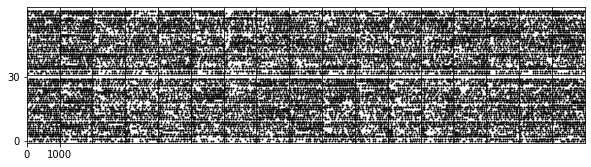

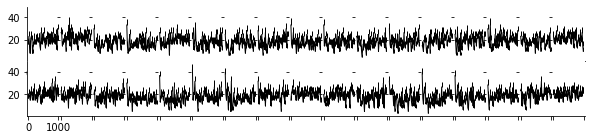

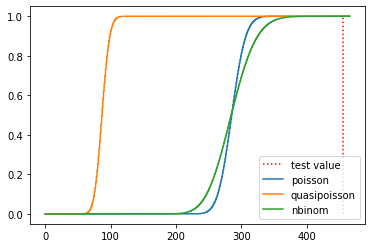

[ 2. 17. 30.]


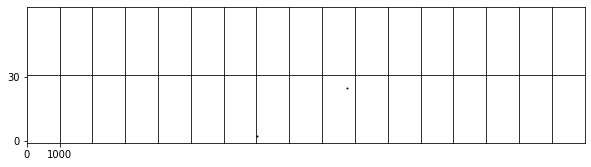

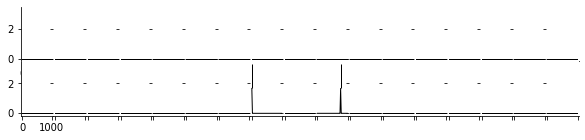

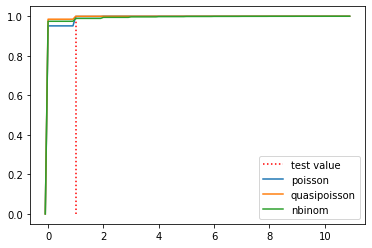

[ 2. 17. 30.]


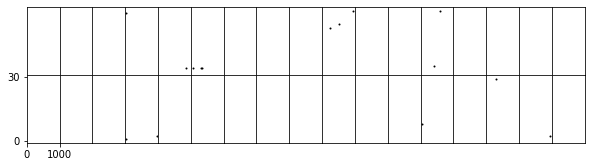

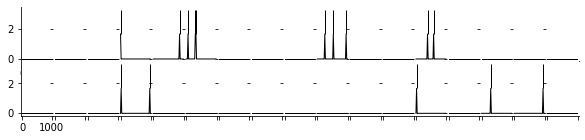

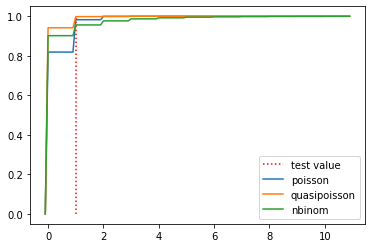

[ 2. 17. 30.]


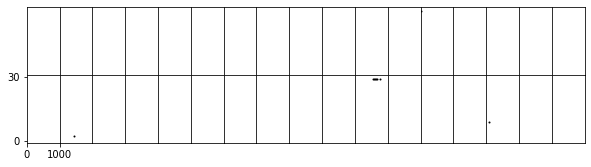

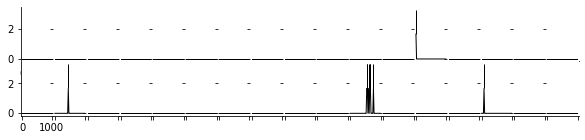

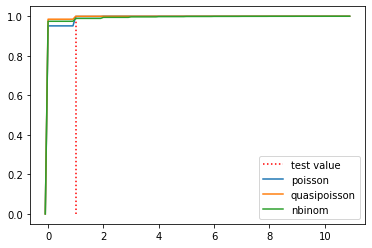

[ 2. 17. 30.]


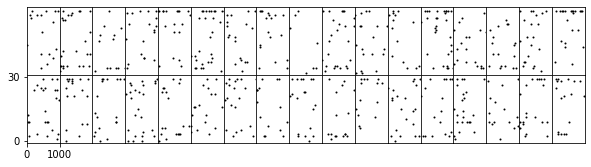

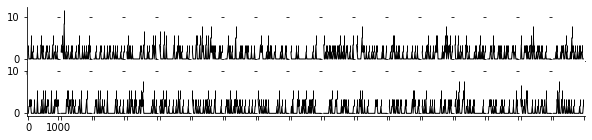

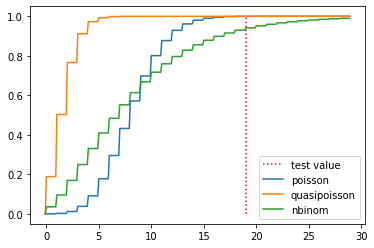

[ 2. 17. 30.]


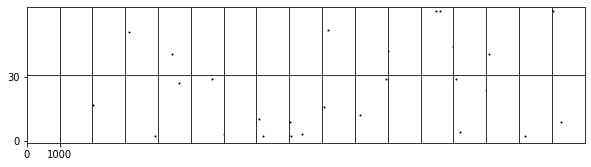

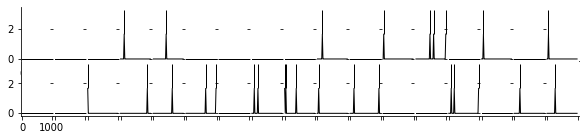

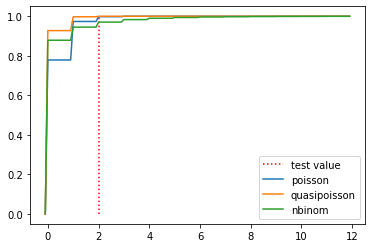

[ 2. 17. 30.]


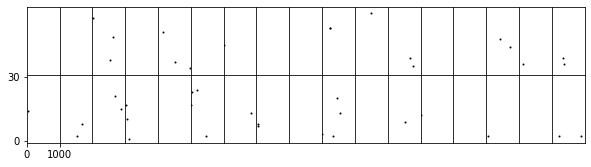

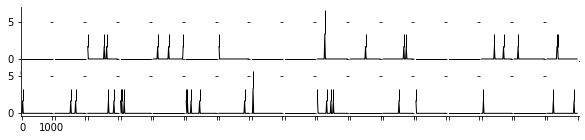

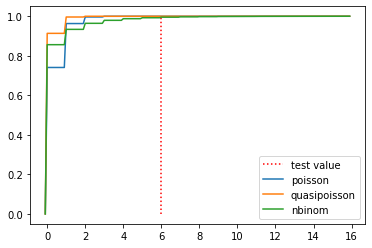

[ 2. 17. 30.]


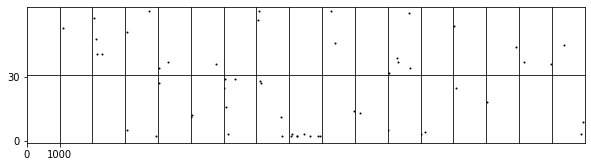

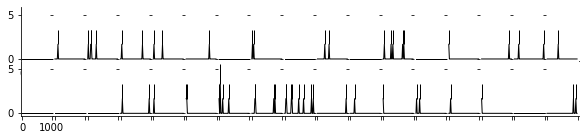

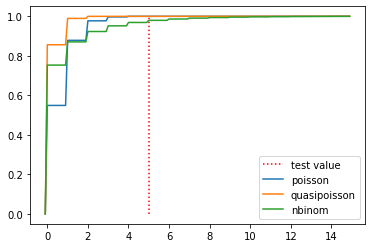

[ 2. 17. 30.]


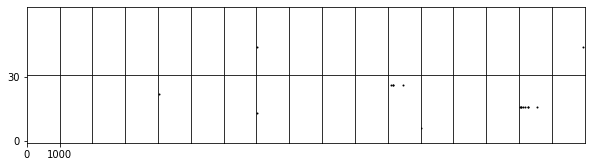

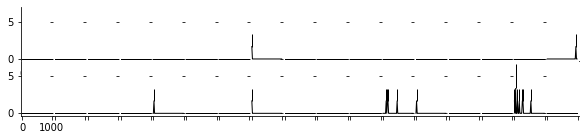

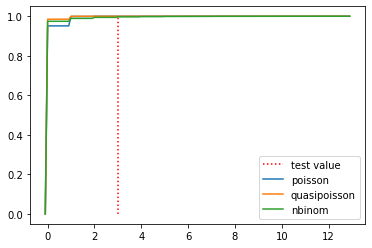

[ 2. 17. 30.]


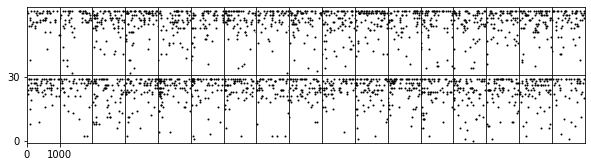

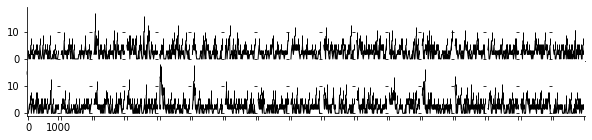

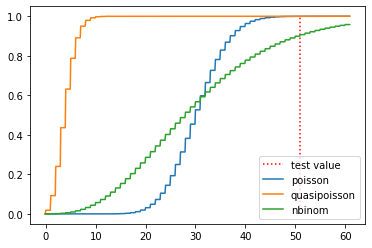

[ 2. 17. 30.]


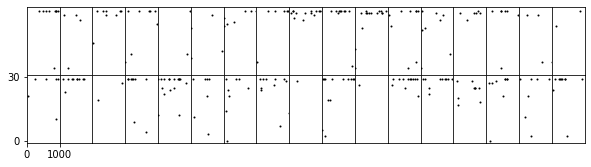

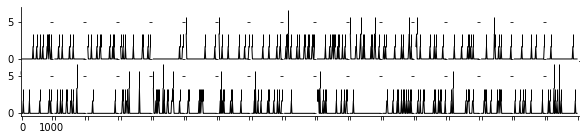

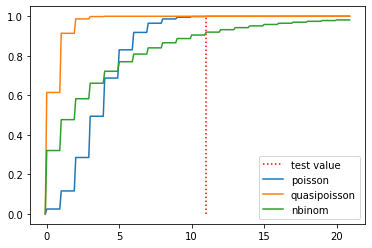

[ 2. 17. 30.]


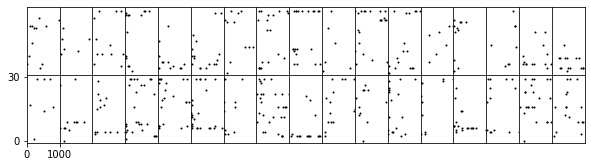

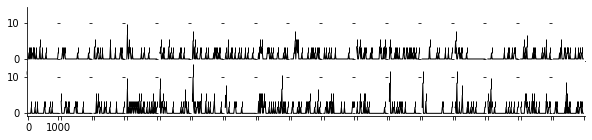

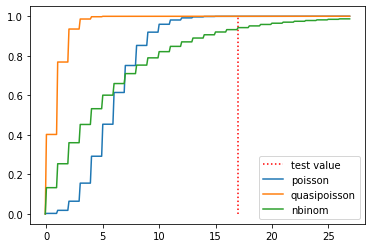

[ 2. 17. 30.]


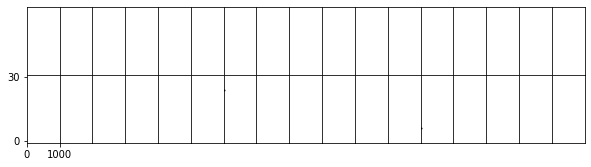

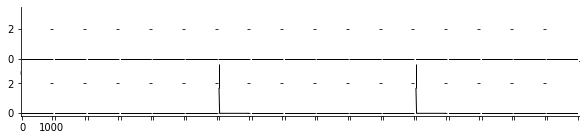

/tmp/ipykernel_953019/3961332994.py:52: RuntimeWarning: invalid value encountered in double_scalars
  segdisper = activity_df.loc[noi, 'var window 700 - 1000 ms']/activity_df.loc[noi, 'avg window 700 - 1000 ms']
/tmp/ipykernel_953019/3961332994.py:56: RuntimeWarning: invalid value encountered in double_scalars
  n = activity_df.loc[noi, 'avg window 700 - 1000 ms']**2*dur*nSeg/1000/(activity_df.loc[noi, 'var window 700 - 1000 ms']-activity_df.loc[noi, 'avg window 700 - 1000 ms'])
/tmp/ipykernel_953019/3961332994.py:57: RuntimeWarning: invalid value encountered in double_scalars
  p = activity_df.loc[noi, 'avg window 700 - 1000 ms']/activity_df.loc[noi, 'var window 700 - 1000 ms']


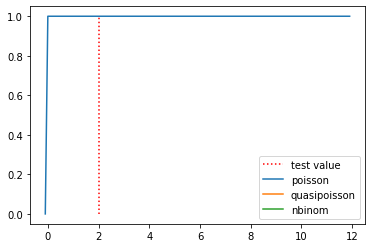

[ 2. 17. 30.]


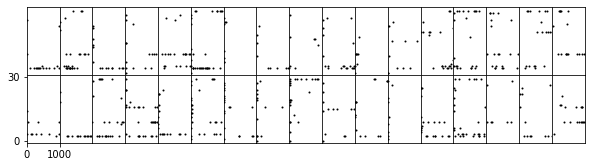

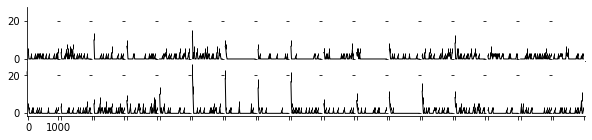

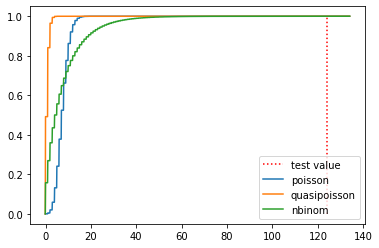

[ 2. 17. 30.]


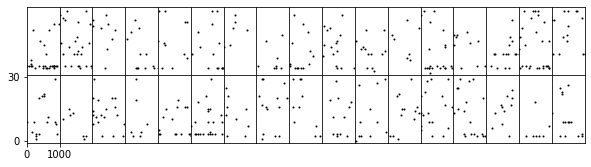

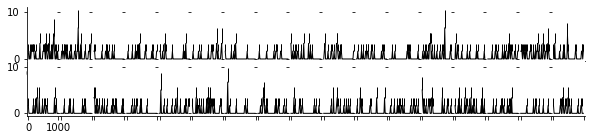

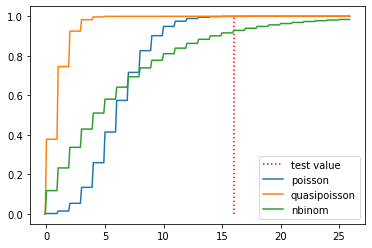

[ 2. 17. 30.]


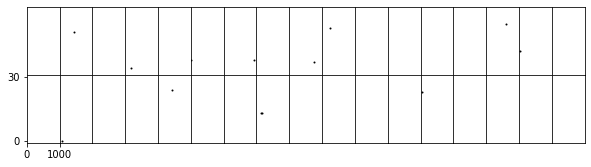

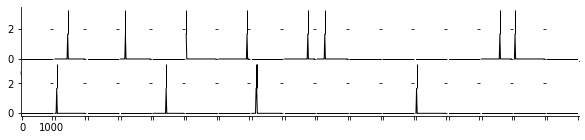

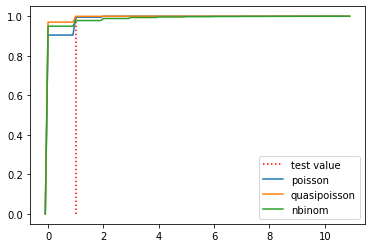

[ 2. 17. 30.]


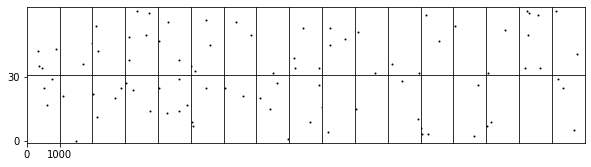

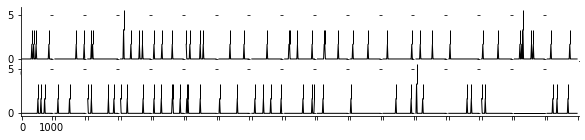

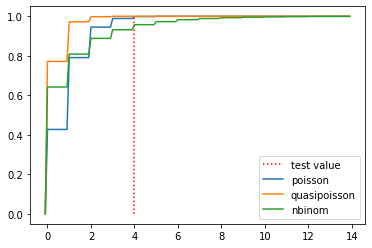

[ 2. 17. 30.]


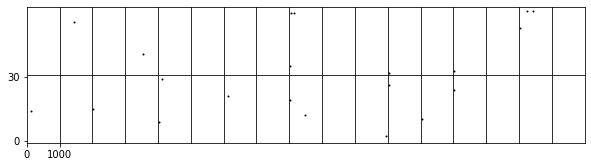

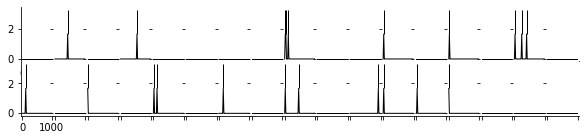

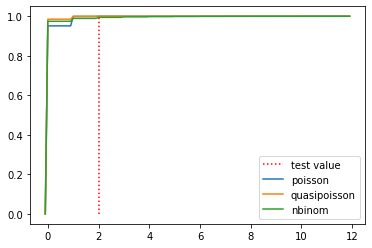

[ 2. 17. 30.]


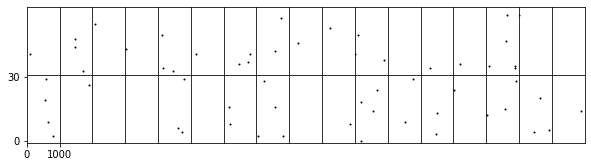

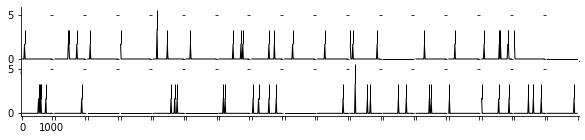

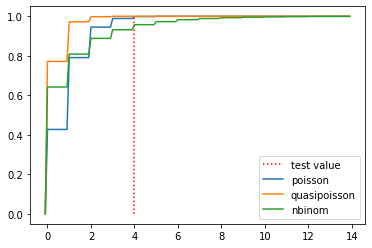

[ 2. 17. 30.]


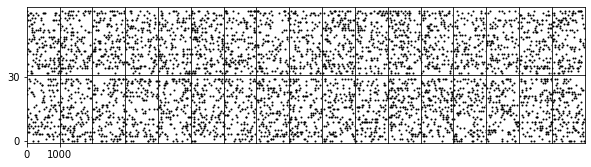

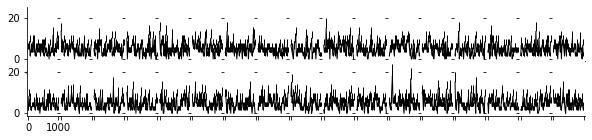

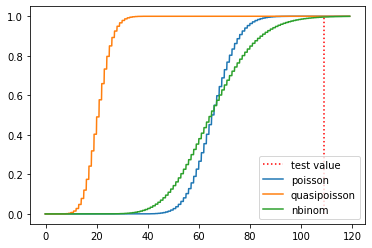

[ 2. 17. 30.]


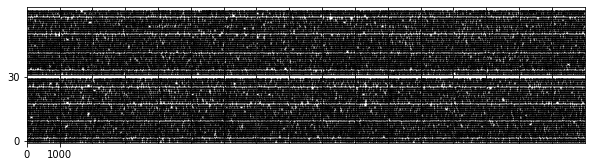

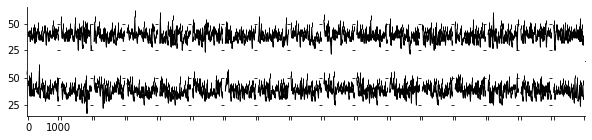

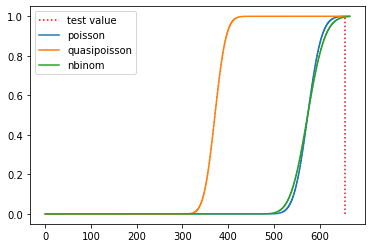

[ 2. 17. 30.]


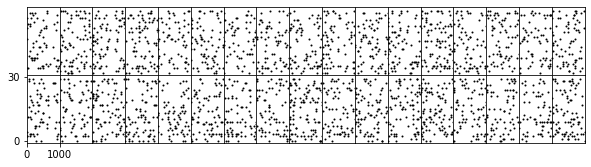

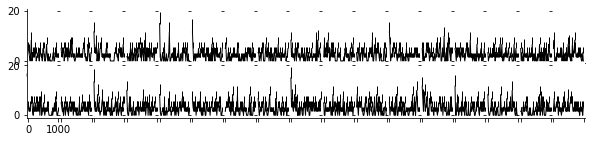

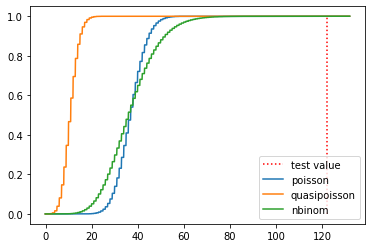

[ 2. 17. 30.]


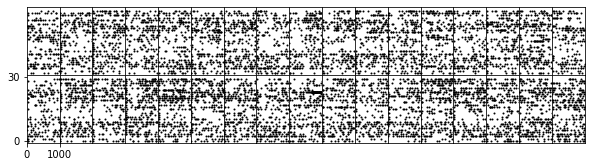

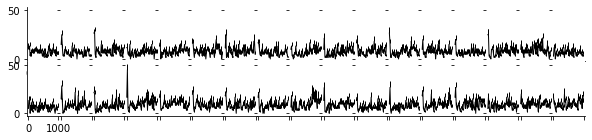

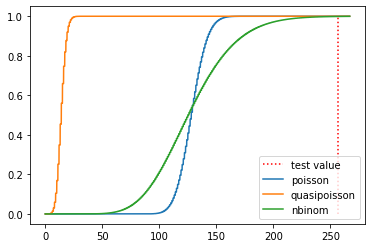

[ 2. 17. 30.]


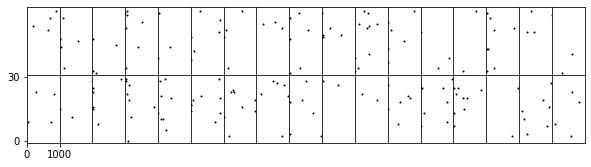

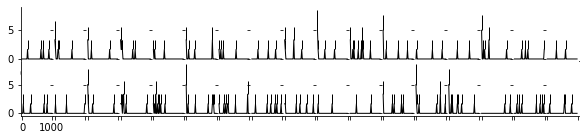

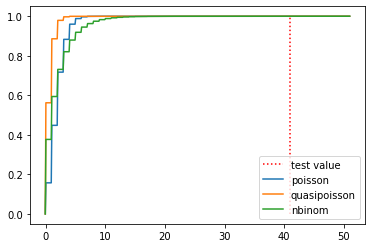

[ 2. 17. 30.]


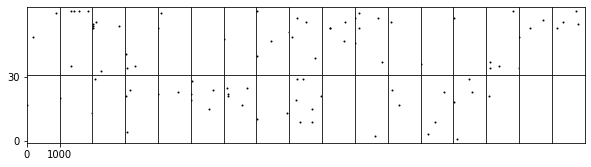

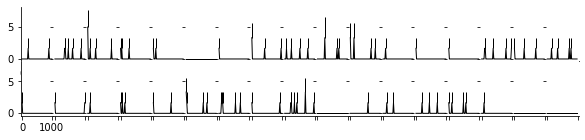

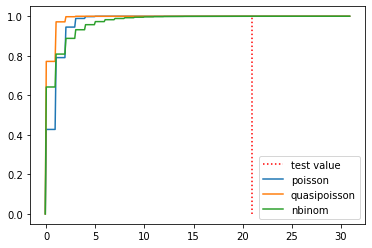

[ 2. 17. 30.]


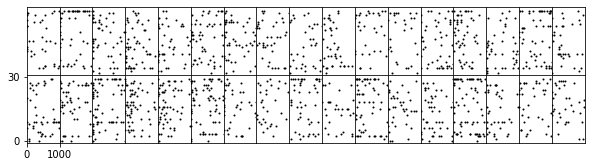

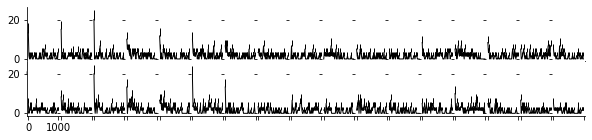

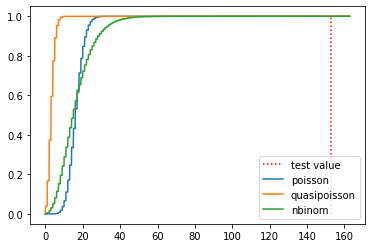

[ 2. 17. 30.]


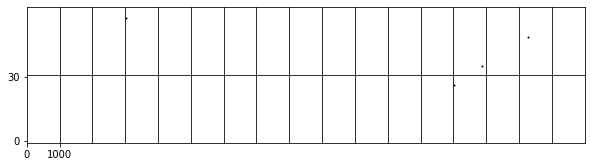

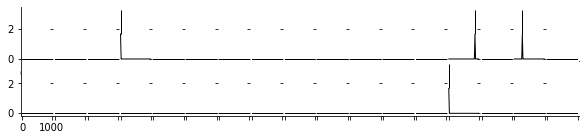

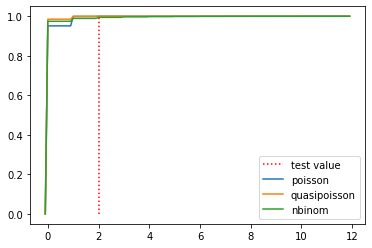

[ 2. 17. 30.]


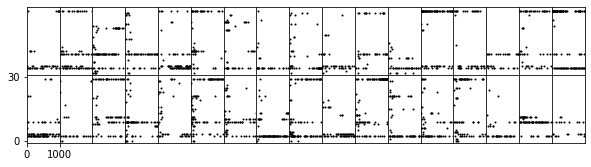

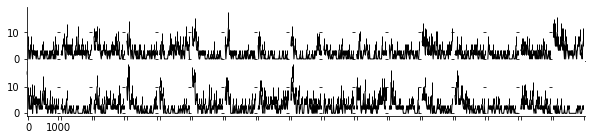

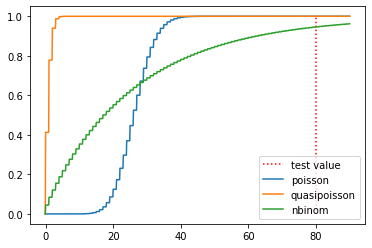

[ 2. 17. 30.]


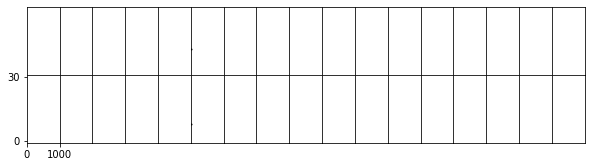

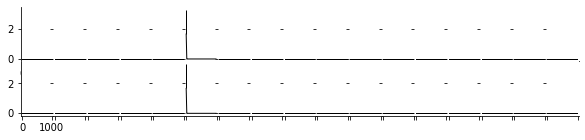

/tmp/ipykernel_953019/3961332994.py:52: RuntimeWarning: invalid value encountered in double_scalars
  segdisper = activity_df.loc[noi, 'var window 700 - 1000 ms']/activity_df.loc[noi, 'avg window 700 - 1000 ms']
/tmp/ipykernel_953019/3961332994.py:56: RuntimeWarning: invalid value encountered in double_scalars
  n = activity_df.loc[noi, 'avg window 700 - 1000 ms']**2*dur*nSeg/1000/(activity_df.loc[noi, 'var window 700 - 1000 ms']-activity_df.loc[noi, 'avg window 700 - 1000 ms'])
/tmp/ipykernel_953019/3961332994.py:57: RuntimeWarning: invalid value encountered in double_scalars
  p = activity_df.loc[noi, 'avg window 700 - 1000 ms']/activity_df.loc[noi, 'var window 700 - 1000 ms']


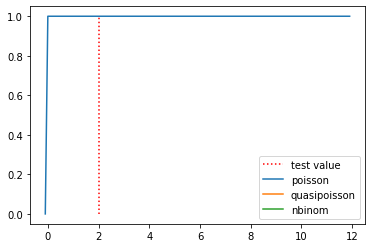

[ 2. 17. 30.]


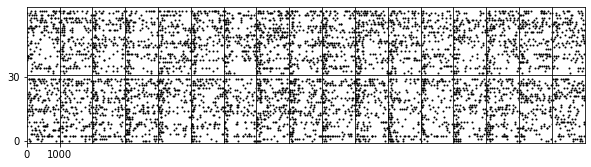

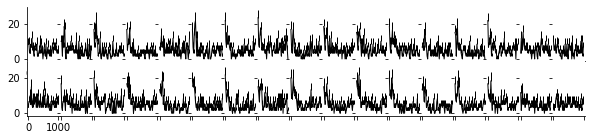

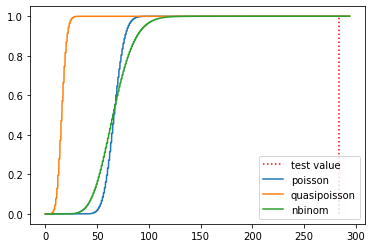

[ 2. 17. 30.]


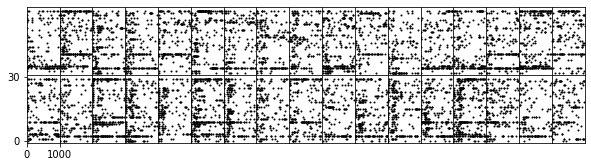

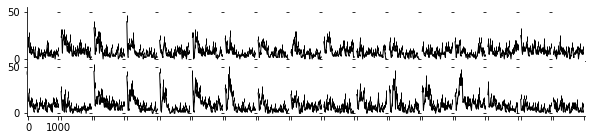

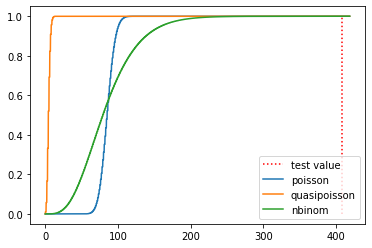

[ 2. 17. 30.]


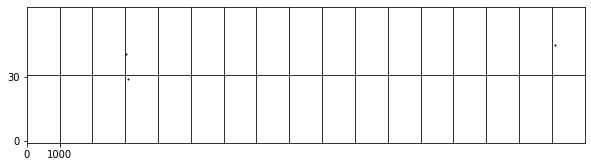

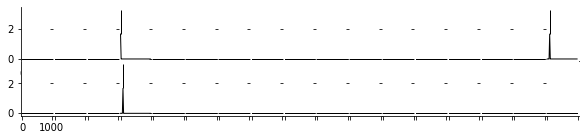

/tmp/ipykernel_953019/3961332994.py:52: RuntimeWarning: invalid value encountered in double_scalars
  segdisper = activity_df.loc[noi, 'var window 700 - 1000 ms']/activity_df.loc[noi, 'avg window 700 - 1000 ms']
/tmp/ipykernel_953019/3961332994.py:56: RuntimeWarning: invalid value encountered in double_scalars
  n = activity_df.loc[noi, 'avg window 700 - 1000 ms']**2*dur*nSeg/1000/(activity_df.loc[noi, 'var window 700 - 1000 ms']-activity_df.loc[noi, 'avg window 700 - 1000 ms'])
/tmp/ipykernel_953019/3961332994.py:57: RuntimeWarning: invalid value encountered in double_scalars
  p = activity_df.loc[noi, 'avg window 700 - 1000 ms']/activity_df.loc[noi, 'var window 700 - 1000 ms']


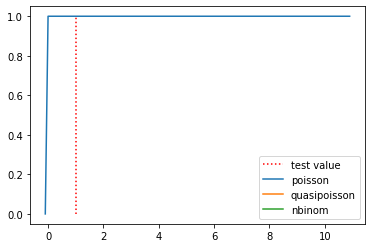

[ 2. 17. 30.]


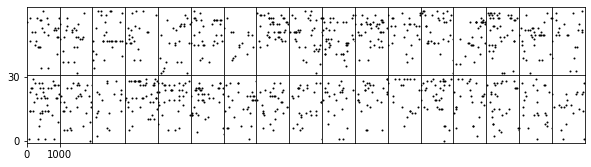

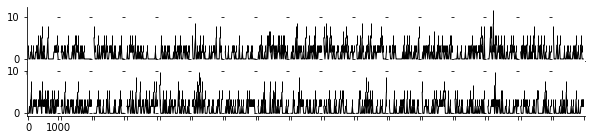

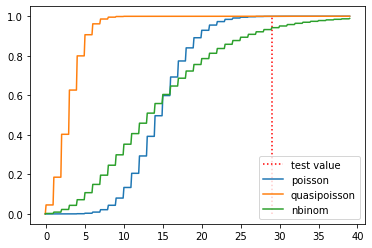

[ 2. 17. 30.]


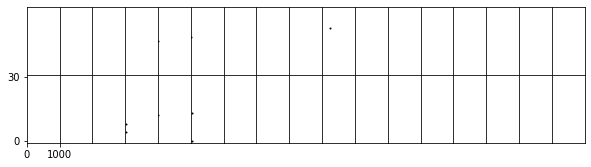

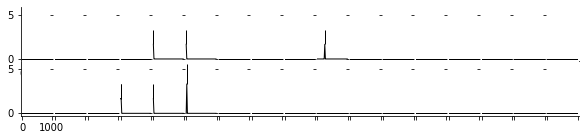

/tmp/ipykernel_953019/3961332994.py:52: RuntimeWarning: invalid value encountered in double_scalars
  segdisper = activity_df.loc[noi, 'var window 700 - 1000 ms']/activity_df.loc[noi, 'avg window 700 - 1000 ms']
/tmp/ipykernel_953019/3961332994.py:56: RuntimeWarning: invalid value encountered in double_scalars
  n = activity_df.loc[noi, 'avg window 700 - 1000 ms']**2*dur*nSeg/1000/(activity_df.loc[noi, 'var window 700 - 1000 ms']-activity_df.loc[noi, 'avg window 700 - 1000 ms'])
/tmp/ipykernel_953019/3961332994.py:57: RuntimeWarning: invalid value encountered in double_scalars
  p = activity_df.loc[noi, 'avg window 700 - 1000 ms']/activity_df.loc[noi, 'var window 700 - 1000 ms']


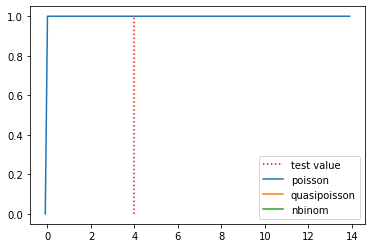

[ 2. 17. 30.]


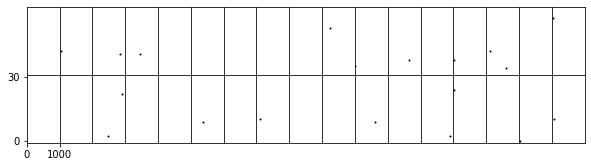

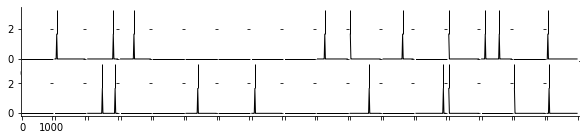

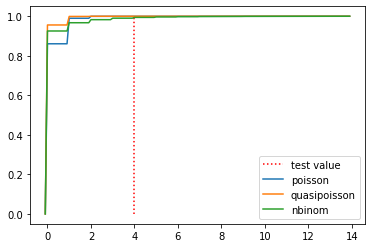

[ 2. 17. 30.]


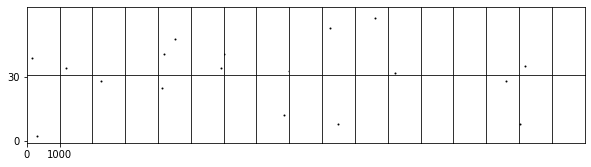

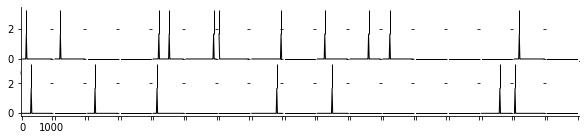

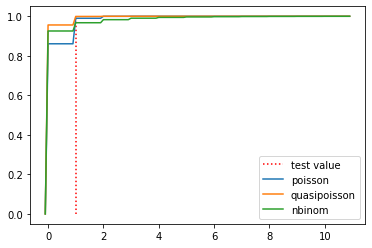

[ 2. 17. 30.]


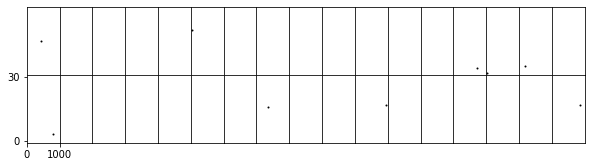

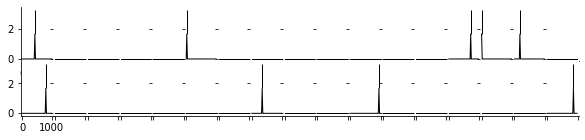

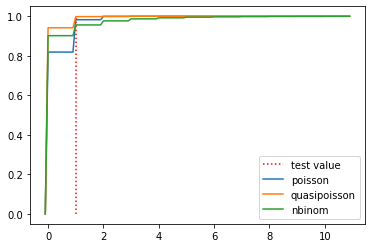

[ 2. 17. 30.]


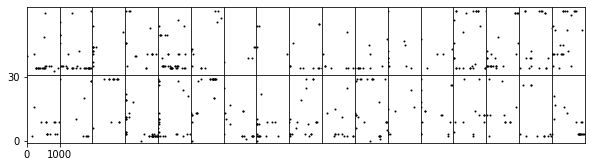

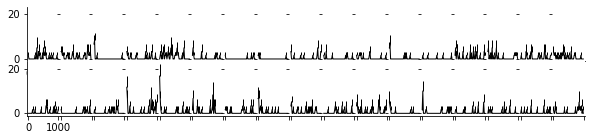

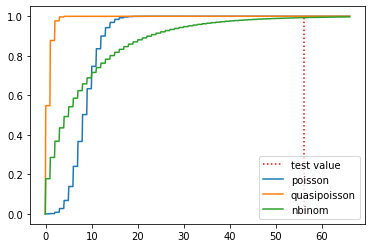

[ 2. 17. 30.]


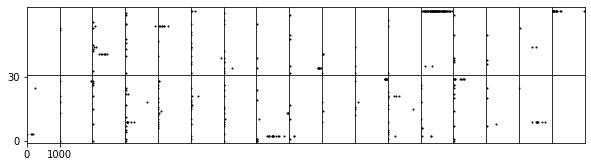

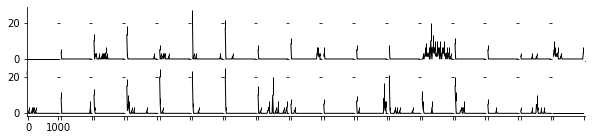

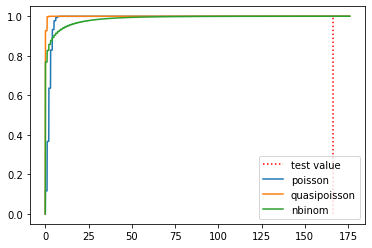

[ 2. 17. 30.]


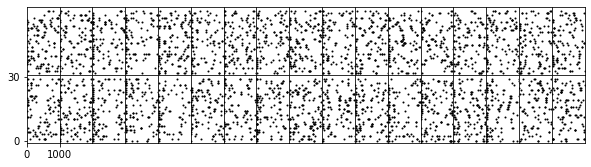

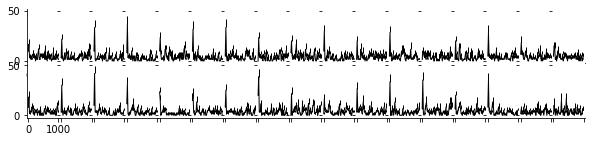

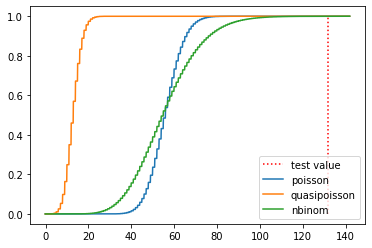

In [28]:
auditory = np.where(compare)[0]
for noi in auditory:

    PatternRaster3d(pattern3d=pattern[0][noi], timerange=timewindow)

    timeBinSz = 20
    fr = PatternToCount(pattern=pattern, timeBinSz=timeBinSz, timerange=timewindow, vis=False)

    nmean = np.squeeze(np.mean(fr[noi]*1000/timeBinSz, axis = 2))
    nsem = np.squeeze(np.std(fr[noi]*1000/timeBinSz, axis = 2))/np.sqrt(30)

    fig, axs = plt.subplots(fr.shape[1], fr.shape[2], figsize =(10,2), sharey=True)

    xs = np.arange(fr.shape[-1])
    if fr.shape[1]==1:
        for i in range(fr.shape[2]):
            axs[i].errorbar(xs, nmean[i], yerr=[np.zeros_like(nsem[i]), nsem[i]], color='k', linewidth=1)
            if i != 0:
                axs[i].set_xticklabels([])
                axs[i].spines[['left','right', 'top']].set_visible(False)
            else:
                axs[i].spines[['right', 'top']].set_visible(False)
        axs[0].set_xticks([xs[0], xs[-1]])
        axs[0].set_xticklabels(timewindow)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()    
    else:
        for j in range(fr.shape[1]):
            for i in range(fr.shape[2]):
                axs[j][i].errorbar(xs, nmean[j][i], yerr=[np.zeros_like(nsem[j][i]), nsem[j][i]], color='k', linewidth=1)
                if i != 0:
                    axs[j][i].set_xticklabels([])
                    axs[j][i].spines[['left','right', 'top']].set_visible(False)
                else:
                    axs[j][i].spines[['right', 'top']].set_visible(False)
        axs[fr.shape[1]-1][0].set_xticks([xs[0], xs[-1]])
        axs[fr.shape[1]-1][0].set_xticklabels(timewindow)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

    dur = 15
    nSeg = 1020

    t = activity_df.loc[noi, 'avg window 5 - 20 ms']*dur*nSeg/1000
    plt.vlines(t,0,1, color='r', linestyle=':', label='test value')

    interp = np.arange(-1,t*10+100)/10

    lamb = activity_df.loc[noi, 'avg window 700 - 1000 ms']*dur*nSeg/1000
    plt.plot(interp, poisson.cdf(interp, mu=lamb), label='poisson')

    segdisper = activity_df.loc[noi, 'var window 700 - 1000 ms']/activity_df.loc[noi, 'avg window 700 - 1000 ms']
    lamb = activity_df.loc[noi, 'avg window 700 - 1000 ms']/segdisper*dur*nSeg/1000
    plt.plot(interp, poisson.cdf(interp, mu=lamb), label='quasipoisson')

    n = activity_df.loc[noi, 'avg window 700 - 1000 ms']**2*dur*nSeg/1000/(activity_df.loc[noi, 'var window 700 - 1000 ms']-activity_df.loc[noi, 'avg window 700 - 1000 ms'])
    p = activity_df.loc[noi, 'avg window 700 - 1000 ms']/activity_df.loc[noi, 'var window 700 - 1000 ms']
    plt.plot(interp, nbinom.cdf(interp, n, p), label='nbinom')

    plt.legend()
    plt.show()



In [29]:
compare = f2(np.array(activity_df['poisson win 0 pos'].values)) - \
          f2(np.array(activity_df['nbinom win 0 pos'].values))

nbin_only = np.where(compare==-1)[0]
pois_only = np.where(compare==1)[0]

[ 2. 17. 30.]


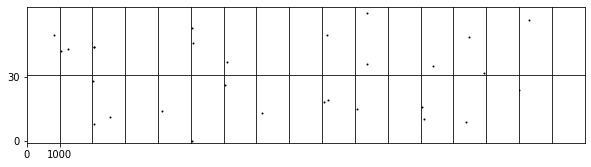

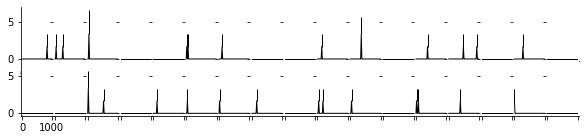

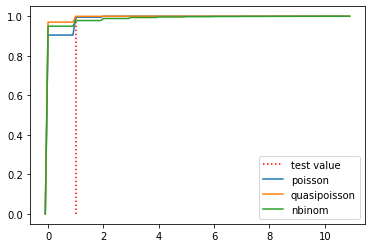

[ 2. 17. 30.]


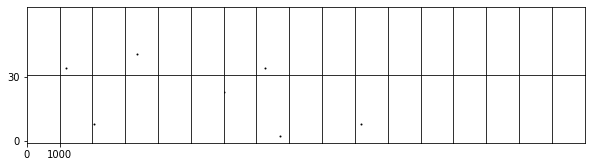

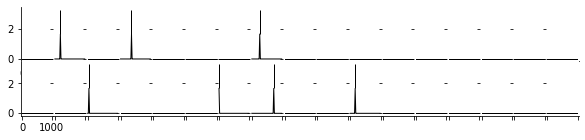

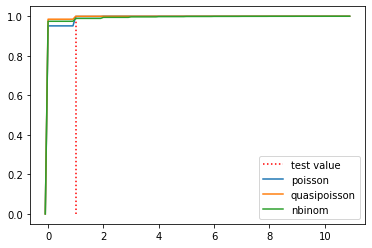

[ 2. 17. 30.]


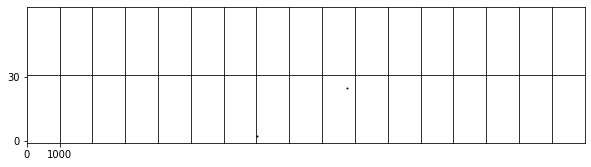

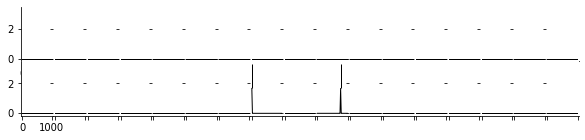

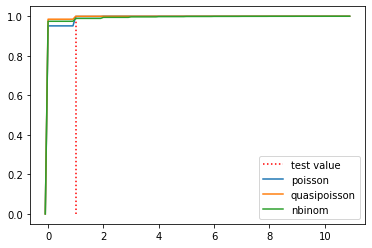

[ 2. 17. 30.]


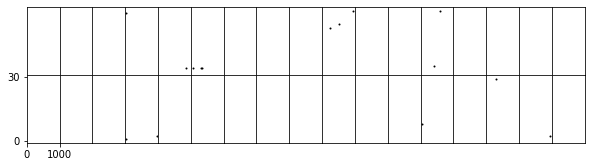

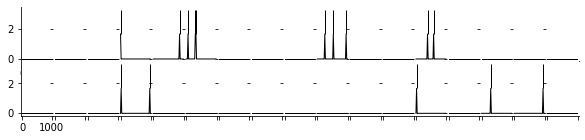

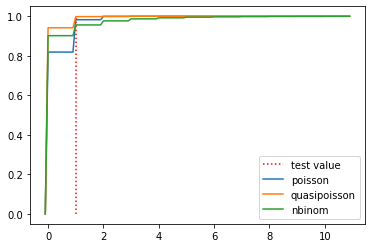

[ 2. 17. 30.]


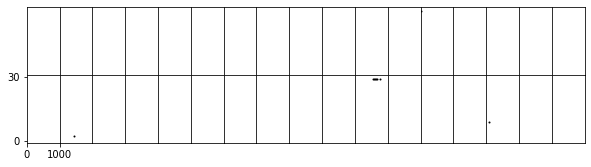

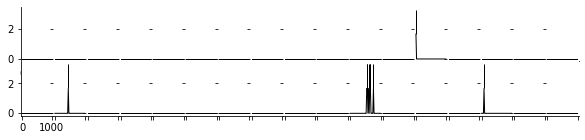

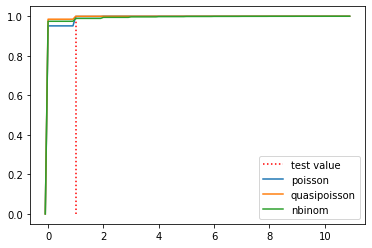

[ 2. 17. 30.]


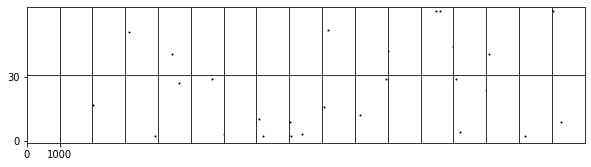

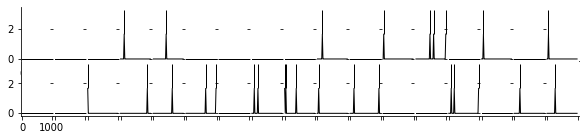

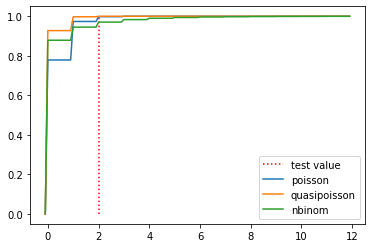

[ 2. 17. 30.]


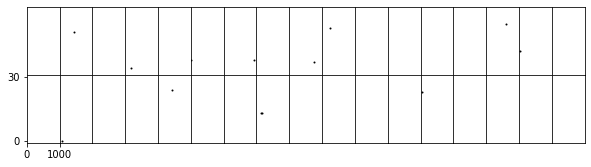

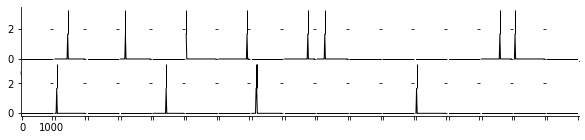

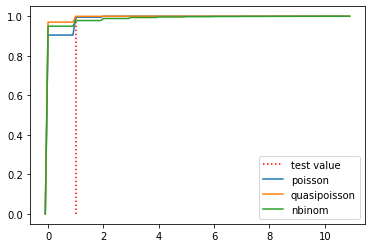

[ 2. 17. 30.]


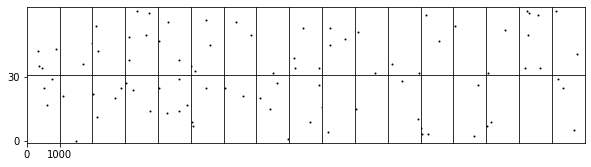

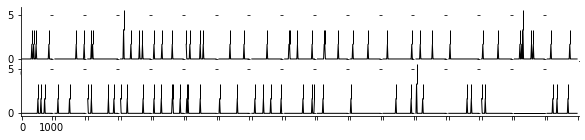

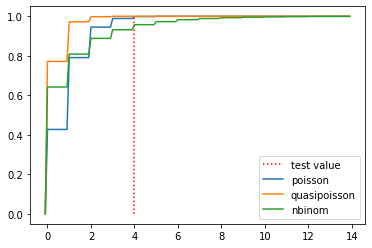

[ 2. 17. 30.]


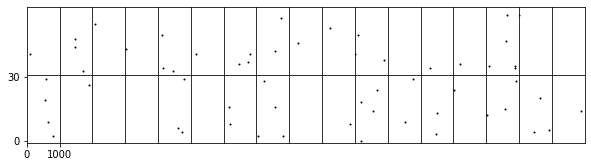

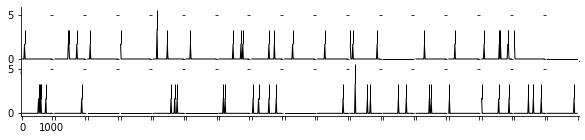

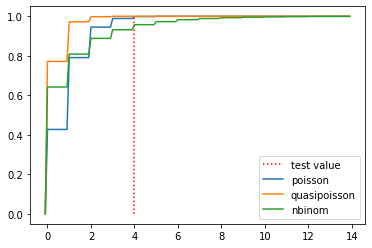

[ 2. 17. 30.]


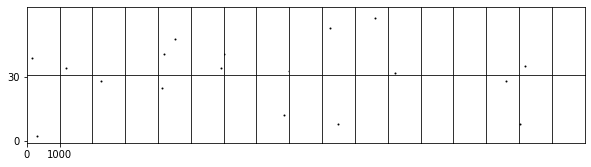

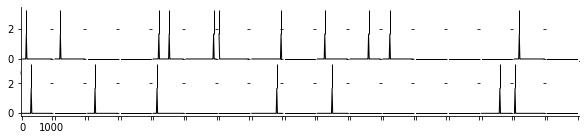

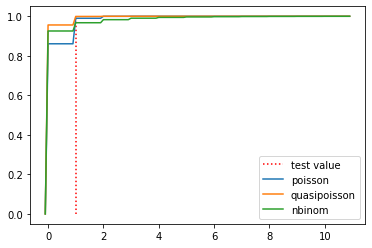

[ 2. 17. 30.]


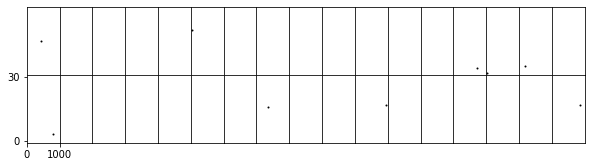

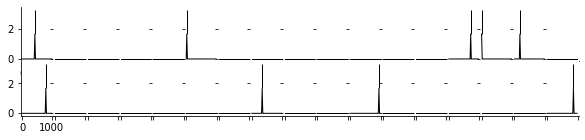

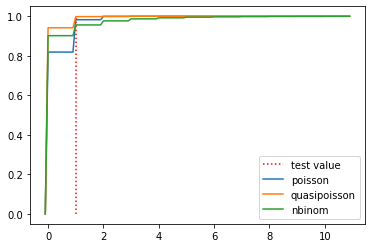

In [30]:
for noi in nbin_only:

    PatternRaster3d(pattern3d=pattern[0][noi], timerange=timewindow)

    timeBinSz = 20
    fr = PatternToCount(pattern=pattern, timeBinSz=timeBinSz, timerange=timewindow, vis=False)

    nmean = np.squeeze(np.mean(fr[noi]*1000/timeBinSz, axis = 2))
    nsem = np.squeeze(np.std(fr[noi]*1000/timeBinSz, axis = 2))/np.sqrt(30)

    fig, axs = plt.subplots(fr.shape[1], fr.shape[2], figsize =(10,2), sharey=True)

    xs = np.arange(fr.shape[-1])
    if fr.shape[1]==1:
        for i in range(fr.shape[2]):
            axs[i].errorbar(xs, nmean[i], yerr=[np.zeros_like(nsem[i]), nsem[i]], color='k', linewidth=1)
            if i != 0:
                axs[i].set_xticklabels([])
                axs[i].spines[['left','right', 'top']].set_visible(False)
            else:
                axs[i].spines[['right', 'top']].set_visible(False)
        axs[0].set_xticks([xs[0], xs[-1]])
        axs[0].set_xticklabels(timewindow)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()    
    else:
        for j in range(fr.shape[1]):
            for i in range(fr.shape[2]):
                axs[j][i].errorbar(xs, nmean[j][i], yerr=[np.zeros_like(nsem[j][i]), nsem[j][i]], color='k', linewidth=1)
                if i != 0:
                    axs[j][i].set_xticklabels([])
                    axs[j][i].spines[['left','right', 'top']].set_visible(False)
                else:
                    axs[j][i].spines[['right', 'top']].set_visible(False)
        axs[fr.shape[1]-1][0].set_xticks([xs[0], xs[-1]])
        axs[fr.shape[1]-1][0].set_xticklabels(timewindow)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

    dur = 15
    nSeg = 1020

    t = activity_df.loc[noi, 'avg window 5 - 20 ms']*dur*nSeg/1000
    plt.vlines(t,0,1, color='r', linestyle=':', label='test value')

    interp = np.arange(-1,t*10+100)/10

    lamb = activity_df.loc[noi, 'avg window 700 - 1000 ms']*dur*nSeg/1000
    plt.plot(interp, poisson.cdf(interp, mu=lamb), label='poisson')

    segdisper = activity_df.loc[noi, 'var window 700 - 1000 ms']/activity_df.loc[noi, 'avg window 700 - 1000 ms']
    lamb = activity_df.loc[noi, 'avg window 700 - 1000 ms']/segdisper*dur*nSeg/1000
    plt.plot(interp, poisson.cdf(interp, mu=lamb), label='quasipoisson')

    n = activity_df.loc[noi, 'avg window 700 - 1000 ms']**2*dur*nSeg/1000/(activity_df.loc[noi, 'var window 700 - 1000 ms']-activity_df.loc[noi, 'avg window 700 - 1000 ms'])
    p = activity_df.loc[noi, 'avg window 700 - 1000 ms']/activity_df.loc[noi, 'var window 700 - 1000 ms']
    plt.plot(interp, nbinom.cdf(interp, n, p), label='nbinom')

    plt.legend()
    plt.show()



[ 2. 17. 30.]


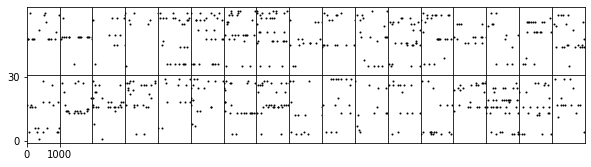

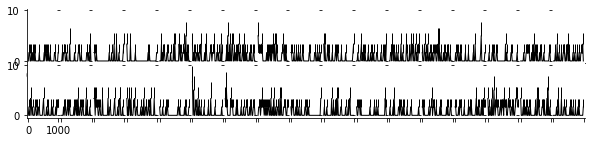

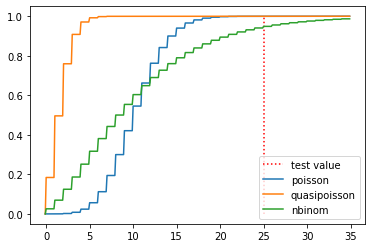

[ 2. 17. 30.]


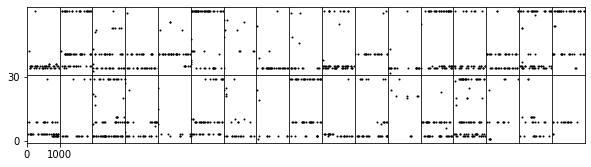

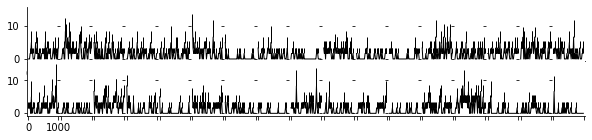

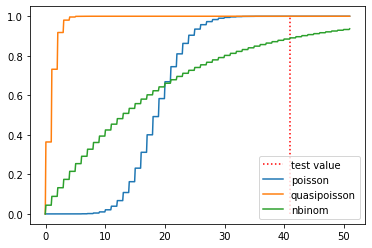

[ 2. 17. 30.]


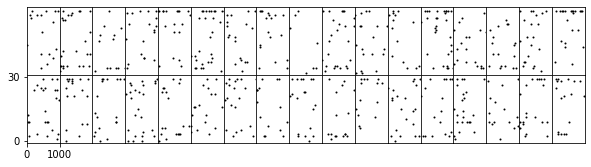

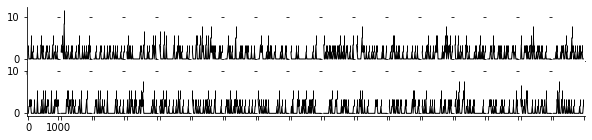

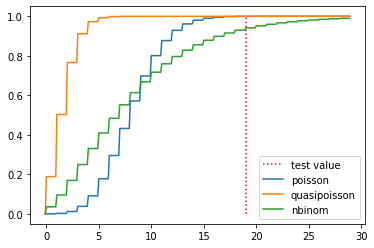

[ 2. 17. 30.]


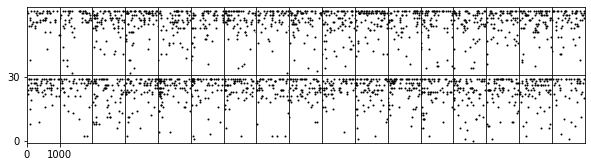

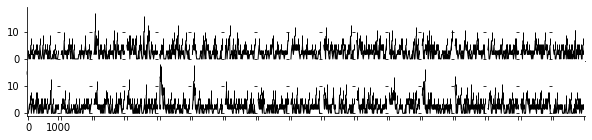

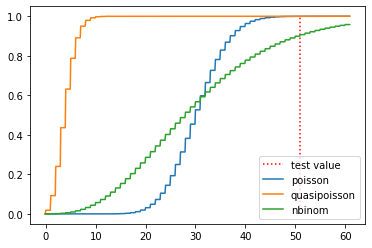

[ 2. 17. 30.]


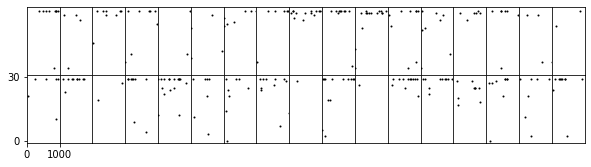

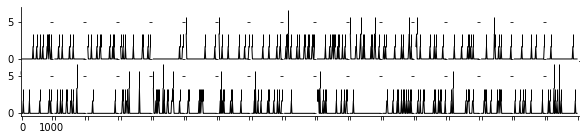

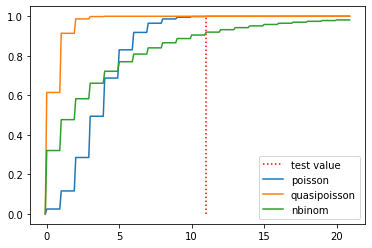

[ 2. 17. 30.]


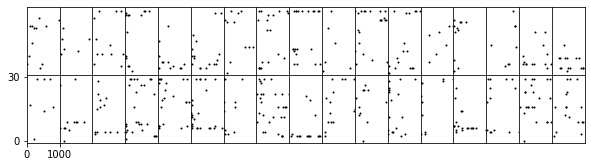

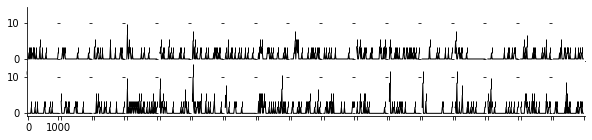

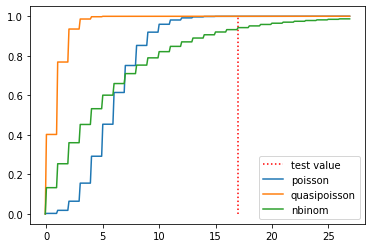

[ 2. 17. 30.]


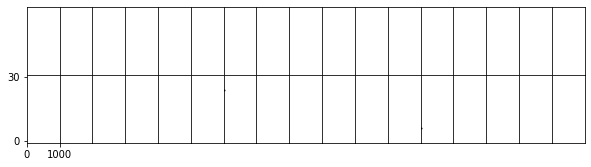

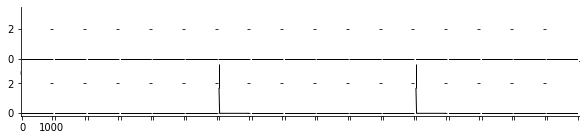

/tmp/ipykernel_953019/1329099892.py:51: RuntimeWarning: invalid value encountered in double_scalars
  segdisper = activity_df.loc[noi, 'var window 700 - 1000 ms']/activity_df.loc[noi, 'avg window 700 - 1000 ms']
/tmp/ipykernel_953019/1329099892.py:55: RuntimeWarning: invalid value encountered in double_scalars
  n = activity_df.loc[noi, 'avg window 700 - 1000 ms']**2*dur*nSeg/1000/(activity_df.loc[noi, 'var window 700 - 1000 ms']-activity_df.loc[noi, 'avg window 700 - 1000 ms'])
/tmp/ipykernel_953019/1329099892.py:56: RuntimeWarning: invalid value encountered in double_scalars
  p = activity_df.loc[noi, 'avg window 700 - 1000 ms']/activity_df.loc[noi, 'var window 700 - 1000 ms']


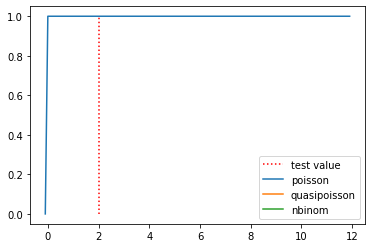

[ 2. 17. 30.]


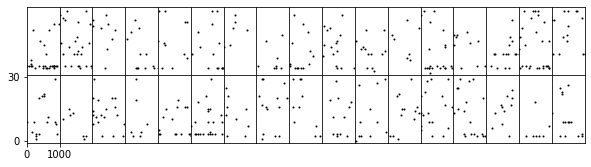

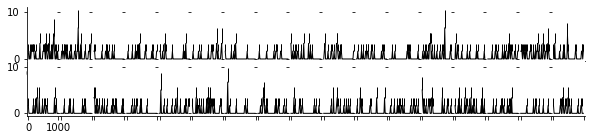

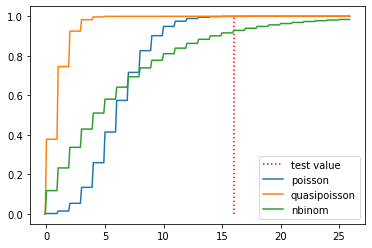

[ 2. 17. 30.]


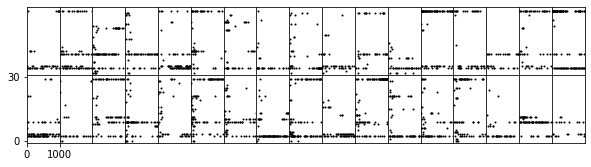

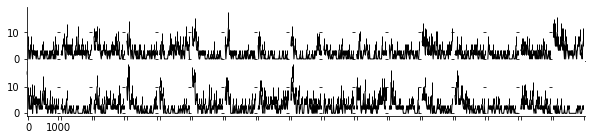

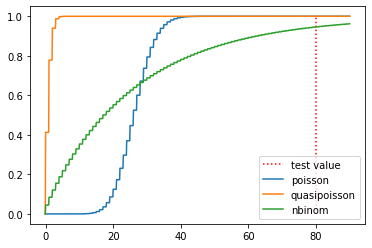

[ 2. 17. 30.]


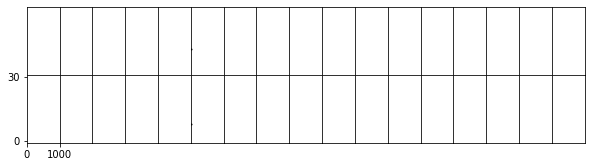

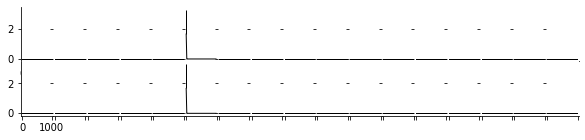

/tmp/ipykernel_953019/1329099892.py:51: RuntimeWarning: invalid value encountered in double_scalars
  segdisper = activity_df.loc[noi, 'var window 700 - 1000 ms']/activity_df.loc[noi, 'avg window 700 - 1000 ms']
/tmp/ipykernel_953019/1329099892.py:55: RuntimeWarning: invalid value encountered in double_scalars
  n = activity_df.loc[noi, 'avg window 700 - 1000 ms']**2*dur*nSeg/1000/(activity_df.loc[noi, 'var window 700 - 1000 ms']-activity_df.loc[noi, 'avg window 700 - 1000 ms'])
/tmp/ipykernel_953019/1329099892.py:56: RuntimeWarning: invalid value encountered in double_scalars
  p = activity_df.loc[noi, 'avg window 700 - 1000 ms']/activity_df.loc[noi, 'var window 700 - 1000 ms']


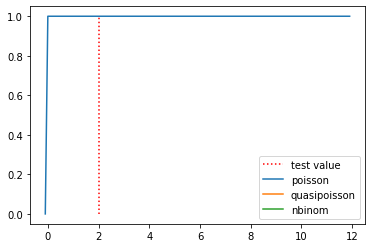

[ 2. 17. 30.]


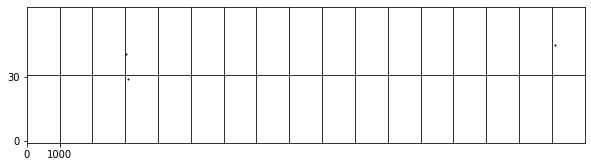

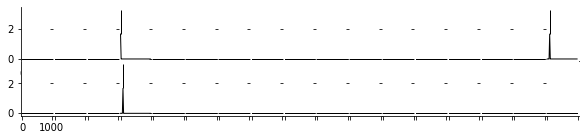

/tmp/ipykernel_953019/1329099892.py:51: RuntimeWarning: invalid value encountered in double_scalars
  segdisper = activity_df.loc[noi, 'var window 700 - 1000 ms']/activity_df.loc[noi, 'avg window 700 - 1000 ms']
/tmp/ipykernel_953019/1329099892.py:55: RuntimeWarning: invalid value encountered in double_scalars
  n = activity_df.loc[noi, 'avg window 700 - 1000 ms']**2*dur*nSeg/1000/(activity_df.loc[noi, 'var window 700 - 1000 ms']-activity_df.loc[noi, 'avg window 700 - 1000 ms'])
/tmp/ipykernel_953019/1329099892.py:56: RuntimeWarning: invalid value encountered in double_scalars
  p = activity_df.loc[noi, 'avg window 700 - 1000 ms']/activity_df.loc[noi, 'var window 700 - 1000 ms']


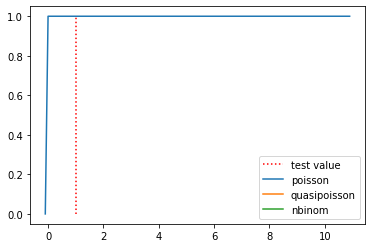

[ 2. 17. 30.]


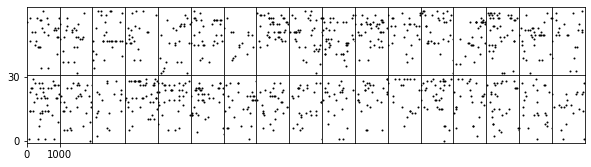

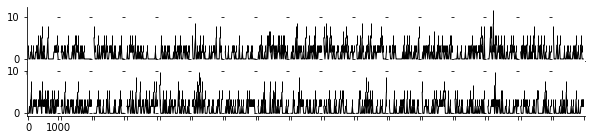

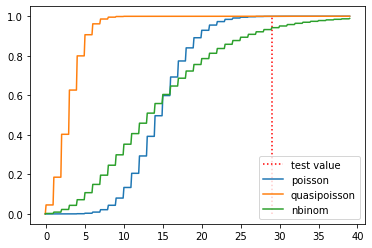

[ 2. 17. 30.]


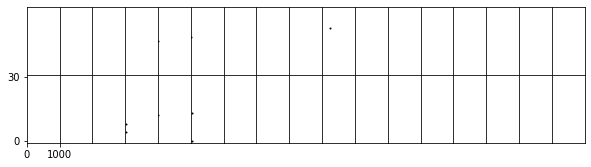

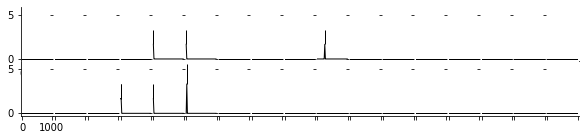

/tmp/ipykernel_953019/1329099892.py:51: RuntimeWarning: invalid value encountered in double_scalars
  segdisper = activity_df.loc[noi, 'var window 700 - 1000 ms']/activity_df.loc[noi, 'avg window 700 - 1000 ms']
/tmp/ipykernel_953019/1329099892.py:55: RuntimeWarning: invalid value encountered in double_scalars
  n = activity_df.loc[noi, 'avg window 700 - 1000 ms']**2*dur*nSeg/1000/(activity_df.loc[noi, 'var window 700 - 1000 ms']-activity_df.loc[noi, 'avg window 700 - 1000 ms'])
/tmp/ipykernel_953019/1329099892.py:56: RuntimeWarning: invalid value encountered in double_scalars
  p = activity_df.loc[noi, 'avg window 700 - 1000 ms']/activity_df.loc[noi, 'var window 700 - 1000 ms']


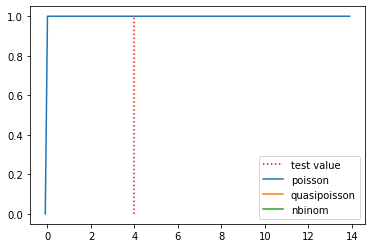

In [31]:
for noi in pois_only:

    PatternRaster3d(pattern3d=pattern[0][noi], timerange=timewindow)

    timeBinSz = 20
    fr = PatternToCount(pattern=pattern, timeBinSz=timeBinSz, timerange=timewindow, vis=False)

    nmean = np.squeeze(np.mean(fr[noi]*1000/timeBinSz, axis = 2))
    nsem = np.squeeze(np.std(fr[noi]*1000/timeBinSz, axis = 2))/np.sqrt(30)

    fig, axs = plt.subplots(fr.shape[1], fr.shape[2], figsize =(10,2), sharey=True)

    xs = np.arange(fr.shape[-1])
    if fr.shape[1]==1:
        for i in range(fr.shape[2]):
            axs[i].errorbar(xs, nmean[i], yerr=[np.zeros_like(nsem[i]), nsem[i]], color='k', linewidth=1)
            if i != 0:
                axs[i].set_xticklabels([])
                axs[i].spines[['left','right', 'top']].set_visible(False)
            else:
                axs[i].spines[['right', 'top']].set_visible(False)
        axs[0].set_xticks([xs[0], xs[-1]])
        axs[0].set_xticklabels(timewindow)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()    
    else:
        for j in range(fr.shape[1]):
            for i in range(fr.shape[2]):
                axs[j][i].errorbar(xs, nmean[j][i], yerr=[np.zeros_like(nsem[j][i]), nsem[j][i]], color='k', linewidth=1)
                if i != 0:
                    axs[j][i].set_xticklabels([])
                    axs[j][i].spines[['left','right', 'top']].set_visible(False)
                else:
                    axs[j][i].spines[['right', 'top']].set_visible(False)
        axs[fr.shape[1]-1][0].set_xticks([xs[0], xs[-1]])
        axs[fr.shape[1]-1][0].set_xticklabels(timewindow)
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

    dur = 15
    nSeg = 1020

    t = activity_df.loc[noi, 'avg window 5 - 20 ms']*dur*nSeg/1000
    plt.vlines(t,0,1, color='r', linestyle=':', label='test value')

    interp = np.arange(-1,t*10+100)/10

    lamb = activity_df.loc[noi, 'avg window 700 - 1000 ms']*dur*nSeg/1000
    plt.plot(interp, poisson.cdf(interp, mu=lamb), label='poisson')

    segdisper = activity_df.loc[noi, 'var window 700 - 1000 ms']/activity_df.loc[noi, 'avg window 700 - 1000 ms']
    lamb = activity_df.loc[noi, 'avg window 700 - 1000 ms']/segdisper*dur*nSeg/1000
    plt.plot(interp, poisson.cdf(interp, mu=lamb), label='quasipoisson')

    n = activity_df.loc[noi, 'avg window 700 - 1000 ms']**2*dur*nSeg/1000/(activity_df.loc[noi, 'var window 700 - 1000 ms']-activity_df.loc[noi, 'avg window 700 - 1000 ms'])
    p = activity_df.loc[noi, 'avg window 700 - 1000 ms']/activity_df.loc[noi, 'var window 700 - 1000 ms']
    plt.plot(interp, nbinom.cdf(interp, n, p), label='nbinom')

    plt.legend()
    plt.show()



In [16]:
nbin = np.sum(activity_df['nbinom win 0 pos full'])
nqpois = np.sum(activity_df['quasipoisson win 0 pos full'])
npois = np.sum(activity_df['poisson win 0 pos full'])
print('Poission auditory pos responsive full: ', npois,\
      '\nQuasipoission auditory pos responsive full: ', nqpois,\
      '\nNeg binomial auditory pos responsive full: ', nbin)

nbin = np.sum(activity_df['nbinom win 0 neg'])
nqpois = np.sum(activity_df['quasipoisson win 0 neg'])
npois = np.sum(activity_df['poisson win 0 neg'])

print('\nPoission auditory neg responsive full: ', npois,\
      '\nQuasipoission auditory neg responsive full: ', nqpois,\
      '\nNeg binomial auditory neg responsive full: ', nbin)

compare = f2(np.array(activity_df['poisson win 0 pos full'].values)) + \
          f2(np.array(activity_df['quasipoisson win 0 pos full'].values)) + \
          f2(np.array(activity_df['nbinom win 0 pos full'].values))
compare2 = f2(np.array(activity_df['poisson win 0 neg full'].values)) + \
          f2(np.array(activity_df['quasipoisson win 0 neg full'].values)) + \
          f2(np.array(activity_df['nbinom win 0 neg full'].values))

print('\nAll three distributions not positive full: ', np.sum(compare==0))
print('Only one distributions found positive full: ',np.sum(compare==1))
print('Only two distributions found positive full: ',np.sum(compare==2))
print('All three distributions found positive full: ',np.sum(compare==3))

print('\nAll three distributions not negative full: ',np.sum(compare2==0))
print('Only one distributions found negative full: ',np.sum(compare2==1))
print('Only two distributions found negative full: ',np.sum(compare2==2))
print('All three distributions found negative full: ',np.sum(compare2==3))

KeyError: 'nbinom win 0 pos full'

In [ ]:
nbin = np.sum(activity_df['nbinom win 0 pos full'])
nqpois = np.sum(activity_df['quasipoisson win 0 pos full'])
npois = np.sum(activity_df['poisson win 0 pos full'])
print('Poission auditory pos responsive full: ', npois,\
      '\nQuasipoission auditory pos responsive full: ', nqpois,\
      '\nNeg binomial auditory pos responsive full: ', nbin)

nbin = np.sum(activity_df['nbinom win 0 neg full'])
nqpois = np.sum(activity_df['quasipoisson win 0 neg full'])
npois = np.sum(activity_df['poisson win 0 neg full'])

print('\nPoission auditory neg responsive full: ', npois,\
      '\nQuasipoission auditory neg responsive full: ', nqpois,\
      '\nNeg binomial auditory neg responsive full: ', nbin)

compare = f2(np.array(activity_df['poisson win 0 pos full'].values)) + \
          f2(np.array(activity_df['poisson win 0 pos'].values))
compare2 = f2(np.array(activity_df['quasipoisson win 0 pos full'].values)) + \
          f2(np.array(activity_df['quasipoisson win 0 pos'].values))
compare3 = f2(np.array(activity_df['nbinom win 0 pos full'].values)) + \
          f2(np.array(activity_df['nbinom win 0 pos'].values))

print('\nBoth poisson methods not positive full: ', np.sum(compare==0))
print('Only one method found positive full: ',np.sum(compare==1))
print('Both method found positive full: ',np.sum(compare==2))

print('\nBoth quasipoisson methods not positive full: ', np.sum(compare2==0))
print('Only one method found positive full: ',np.sum(compare2==1))
print('Both method found positive full: ',np.sum(compare2==2))

print('\nBoth nbinom methods not positive full: ', np.sum(compare3==0))
print('Only one method found positive full: ',np.sum(compare3==1))
print('Both method found positive full: ',np.sum(compare3==2))

In [ ]:

    
fig, axs = plt.subplots(1,3, figsize=(9,3))

axs[0].scatter(activity_df['poisson 0 pos max frac'], 
                activity_df['poisson pval compare win 0 - 1'])
axs[0].plot([0,1],[0,1], linestyle=':')
# axs[0].set_xlabel('poisson')
# axs[0].set_ylabel('quasipoisson')

axs[1].scatter(activity_df['quasipoisson 0 pos max frac'], 
                activity_df['quasipoisson pval compare win 0 - 1'])
axs[1].plot([0,1],[0,1], linestyle=':')
# axs[1].set_xlabel('poisson')
# axs[1].set_ylabel('nbinom')

axs[2].scatter(activity_df['nbinom 0 pos max frac'], 
                activity_df['nbinom pval compare win 0 - 1'])
axs[2].plot([0,1],[0,1], linestyle=':')
# axs[2].set_xlabel('quasipoisson')
# axs[2].set_ylabel('nbinom')
plt.tight_layout()
plt.show()

In [ ]:
# fig, axs = plt.subplots(1,3)

# axs[0].errorbar(activity_df['avg window 700 - 1000 ms'], 
#              activity_df['poisson pval compare win 0 - 1'], 
#              xerr = np.sqrt(activity_df['var window 700 - 1000 ms']), ls='none', marker='s', ms = 5, color='blue')
# axs[1].errorbar(activity_df['avg window 700 - 1000 ms'], 
#              activity_df['quasipoisson pval compare win 0 - 1'], 
#              xerr = np.sqrt(activity_df['var window 700 - 1000 ms']), ls='none', marker='s', ms = 5, color='orange') 
# axs[2].errorbar(activity_df['avg window 700 - 1000 ms'], 
#              activity_df['nbinom pval compare win 0 - 1'], 
#              xerr = np.sqrt(activity_df['var window 700 - 1000 ms']), ls='none', marker='s', ms = 5, color='green') 
# plt.show()

fig, axs = plt.subplots(1,3, figsize=(9,3))

axs[0].errorbar(activity_df['poisson pval compare win 0 - 1'], 
                activity_df['quasipoisson pval compare win 0 - 1'], 
                ls='none', marker='s', ms = 5, color='k', alpha=0.1)
axs[0].plot([0,1],[0,1], linestyle=':')
axs[0].set_xlabel('poisson')
axs[0].set_ylabel('quasipoisson')

axs[1].errorbar(activity_df['poisson pval compare win 0 - 1'], 
                activity_df['nbinom pval compare win 0 - 1'], 
                ls='none', marker='s', ms = 5, color='k', alpha=0.1)
axs[1].plot([0,1],[0,1], linestyle=':')
axs[1].set_xlabel('poisson')
axs[1].set_ylabel('nbinom')

axs[2].errorbar(activity_df['quasipoisson pval compare win 0 - 1'], 
                activity_df['nbinom pval compare win 0 - 1'], 
                ls='none', marker='s', ms = 5, color='k', alpha=0.1)
axs[2].plot([0,1],[0,1], linestyle=':')
axs[2].set_xlabel('quasipoisson')
axs[2].set_ylabel('nbinom')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,3, figsize=(9,3))

# axs[0].errorbar(np.abs(activity_df['poisson pval compare win 0 - 1']-0.5)+0.5, 
#                 activity_df['var window 700 - 1000 ms']/activity_df['avg window 700 - 1000 ms'], 
#                 ls='none', marker='s', ms = 5, color='k', alpha=0.1)
# axs[1].errorbar(np.abs(activity_df['quasipoisson pval compare win 0 - 1']-0.5)+0.5, 
#                 activity_df['var window 700 - 1000 ms']/activity_df['avg window 700 - 1000 ms'], 
#                 ls='none', marker='s', ms = 5, color='k', alpha=0.1)
# axs[2].errorbar(np.abs(activity_df['nbinom pval compare win 0 - 1']-0.5)+0.5, 
#                 activity_df['var window 700 - 1000 ms']/activity_df['avg window 700 - 1000 ms'], 
#                 ls='none', marker='s', ms = 5, color='k', alpha=0.1)

fig, axs = plt.subplots(1,1, figsize=(9,3))

bins = np.arange(0,60)/2

axs.hist(activity_df['var window 700 - 1000 ms']/activity_df['avg window 700 - 1000 ms'], bins=bins)
axs.vlines(1,0,40, color='red', linestyle=':')


In [ ]:
import math
math.gcd(int(spont_win[1]-spont_win[0]),int(windows[0,0]))

In [ ]:
stim_dict = {'seg1':'fullfield.txt',
#            'seg2':'randchord.txt',
#             'seg3':'puretones.txt',
#             'seg4':'BLN_original.txt',
#             'seg5':'horizontal_pupcall_1_120rep.txt',
#             'seg6':'fullfield.txt',
#            'seg7':'randchord.txt',
#             'seg8':'puretones.txt',
#             'seg9':'BLN_original.txt',
#             'seg10':'horizontal_pupcall_1_120rep.txt'
            }

def AnalyzeAuditorySpot(asdf, ttls, 
                        stim_dict=stim_dict, siglevel=0.001, 
                        minspike = 10, limitelv=0, windows=[[5,20],[20,100],[105,120]], 
                        spontwin=[950, 1000], asdf_loco=[]):
    
    nNeu = asdf.shape[0] #n nuerons
    nseg = length(ttls) #n of segments/stimulations
    ntypes = 1000 #n of types of stimulation
    
    nwin = windows.shape[0] #n of windows
    win_fr = cell(nwin, 1); #create storage of values FR per window
    
    [spont_fr, spont_disper] = SegmentFR(asdf, ttls, pr.spontwin(1), pr.spontwin(2));
    for i = 1:nwin
        win_fr{i} = SegmentFR(asdf, ttls, pr.windows(i, 1), pr.windows(i, 2));
    end

#     % get p-values for each window
#     winsize = diff(pr.windows, 1, 2);
#     pvals = zeros(nNeu, nwin);
#     ac_sp = zeros(nNeu, nwin);
#     %minspike = 10; % a parameter. minimum number of spike to consider

#     for i = 1:nwin
#         lambda = spont_fr * winsize(i) / 1000 * nseg; % expected number of spikes
#         ac_sp(:, i) = win_fr{i} * winsize(i) / 1000 * nseg; % actual number of spikes
#         %pvals(:, i) = poisscdf(ac_sp(:, i), lambda);
#         pvals(:, i) = poisscdf(ac_sp(:, i) ./ spont_disper, lambda ./ spont_disper);
#         % divide by dispersion to get overdispersed poisson statistics.
#     end
    
#     % get cells with a positive response
#     %figure;histogram(pvals, 200)
#     pospval = 1-pvals;
#     possig = pospval < pr.siglevel / nwin & ac_sp >= pr.minspike;
#     negsig = pvals < pr.siglevel / nwin & ac_sp >= pr.minspike;
#     posneu = any(possig, 2);
#     negneu = any(negsig, 2);
#     winnumsig = zeros(nwin, 1);
#     winnumsig_n = zeros(nwin, 1);

#     posneu1 = find(pospval(:, 1) < pr.siglevel);
#     %posneu2 = find(any(pospval(:, 2:3) < pr.siglevel / 2, 2));
#     posneu2 = find(pospval(:, 2) < pr.siglevel);
#     posneu3 = find(pospval(:, 3) < pr.siglevel);

#     for i = 1:nwin
#         winnumsig(i) = nnz(possig(:, i));
#         winnumsig_n(i) = nnz(negsig(:, i));
#     end
#     asdf_pos = ASDFSubsample(asdf, find(posneu));
#     patterns = FormatAuditoryPSTH(asdf_pos, ttls, si, 200);
#     patterns_2s = FormatAuditoryPSTH(asdf_pos, ttls, si, 2000);
#     patterns_all = FormatAuditoryPSTH(asdf, ttls, si, 2000);

#     [projs, projs_pn] = AuditoryPSTHAnalysis(patterns_2s, spont_fr(posneu), 13, 0.05, 500);

#     %% after getting the patterns, do running analysis.

#     if ~isempty(pr.asdf_loco)
#         patterns_loco = FormatAuditoryPSTH(pr.asdf_loco, ttls, si, 500);
#         running = PatternToCount(patterns_loco.fullpat, 0, 500) > 3.33;

#         % define spontaneous firing rate for each condition
#         nPos = nnz(posneu);
#         spont_fr_run = zeros(nPos, 1);
#         spont_fr_run_disper = zeros(nPos, 1);
#         spont_fr_stat = zeros(nPos, 1);
#         spont_fr_stat_disper = zeros(nPos, 1);
#         for i = 1:nPos
#             wsize = diff(pr.spontwin);
#             pat = patterns_2s.fullpat(:, :, :, :, i);
#             srcount = cell2mat(PatternToFRhist(pat(running), pr.spontwin));
#             spont_fr_run(i) = mean(srcount) * 1000 / wsize;
#             spont_fr_run_disper(i) =  var(srcount) / mean(srcount);

#             sscount = cell2mat(PatternToFRhist(pat(~running), pr.spontwin));
#             spont_fr_stat(i) = mean(sscount) * 1000 / wsize;
#             spont_fr_stat_disper(i) =  var(sscount) / mean(sscount);
#         end

#         [projs_stat, projs_pn_stat] = AuditoryPSTHAnalysis(patterns_2s, spont_fr_stat, 13, 0.05, 500, ~running);
#         [projs_run, projs_pn_run] = AuditoryPSTHAnalysis(patterns_2s, spont_fr_run, 13, 0.05, 500, running);
#         % a little special treatment here for renormalizing the stat/run
#         normfactor = repmat(1 ./ mean(max(projs, 0), 2), 1, size(projs, 2));
#         projs_renorm_stat = max(projs_stat, 0) .* normfactor;
#         projs_renorm_run = max(projs_run, 0) .* normfactor;

#     else
#         patterns_loco = [];
#         running = [];
#         spont_fr_stat = [];
#         projs_stat = [];
#         projs_pn_stat = [];
#         projs_renorm_stat = [];
#         spont_fr_run = [];
#         projs_run = [];
#         projs_pn_run = [];
#         projs_renorm_run = [];
#         spont_fr_stat_disper = [];
#         spont_fr_run_disper = [];
#     end
#     %%

#     %spatpat = PatternToFRhist(patterns.fullpat(1, :, :, :, :), [5, 25, 60, 200]);
#     %newspatmat = permute(cell2mat(permute(spatpat, [2,1,3,4,5])), [2,1,3,4,5])

#     sf.nSteps1 = length(si.meta2); % nazims
#     sf.nSteps2 = length(si.meta1); % nelevs
#     %patterns.fullpat = psthmat;
#     if strcmp(pr.fittype, 'UMLE') % normal unbinned MLE fit
#         patterns_fit = patterns;
#         if pr.limitelev
#             patterns_fit.fullpat = patterns.fullpat(:, pr.limitelev, :, :, :);
#         end
#         fitresult = calculateAllSpotDataset(patterns_fit, sf, 5);
#     elseif strcmp(pr.fittype, 'Kent') % kent distribution fit
#         asdf_pos1 = ASDFSubsample(asdf, posneu1);
#         patterns1 = FormatAuditoryPSTH(asdf_pos1, ttls, si, pr.windows(1,2));
#         nNeu1 = asdf_pos1{end}(1);
#         nstim = size(patterns1.fullpat, 1);
#         fitresult_stims = cell(nstim, 3);
#         for i = 2:nstim
#             fitresult_stims{i} = cell(nNeu1, 1);
#         end
#         fitresult = cell(4, 1);
#         fitresult{1} = cell(nNeu1, 1);
#         fitresult{3} = cell(nNeu1, 1);
#         fitresult{9} = cell(nNeu1, 1);
#         fitresult{10} = cell(nNeu1, 1);
#         if ~isempty(running)
#             % 5: stationary, 6: running;
#             fitresult{5} = cell(nNeu1, 1);
#             fitresult{6} = cell(nNeu1, 1);
#             fitresult{7} = cell(nNeu1, 1);
#             fitresult{8} = cell(nNeu1, 1);
#         end


#         asdf_pos2 = ASDFSubsample(asdf, posneu2);
#         patterns2 = FormatAuditoryPSTH(asdf_pos2, ttls, si, pr.windows(2,2));
#         nNeu2 = asdf_pos2{end}(1);
#         fitresult{2} = cell(nNeu2, 1);
#         fitresult{4} = cell(nNeu2, 1);
#         firsthalf = running;
#         firsthalf(1, :, :, 1:(end/2)) = 1;
#         firsthalf(1, :, :, (end/2+1):end) = 0;

#         for i = 1:nNeu1
#             %i
#             fitresult{1}{i} = KentFitOneCell(patterns1.fullpat(1,:,:,:,i), 1);
#             fitresult{3}{i} = KentFitOneCell(patterns1.fullpat(1,:,:,:,i), 3);
#             fitresult{9}{i} = KentFitOneCell(patterns1.fullpat(1,:,:,:,i), 9);
#             fitresult{10}{i} = KentFitOneCell(patterns1.fullpat(1,:,:,:,i), 10);
#             if ~isempty(running)
#                 fitresult{5}{i} = KentFitOneCell(patterns1.fullpat(1,:,:,:,i), 3, running(1,:,:,:));
#                 fitresult{6}{i} = KentFitOneCell(patterns1.fullpat(1,:,:,:,i), 3, ~running(1,:,:,:));
#                 fitresult{7}{i} = KentFitOneCell(patterns1.fullpat(1,:,:,:,i), 3, ~firsthalf(1,:,:,:));
#                 fitresult{8}{i} = KentFitOneCell(patterns1.fullpat(1,:,:,:,i), 3, firsthalf(1,:,:,:));
#             end
#             if nstim > 1 % do additional fits
#                 for j = 2:nstim
#                     fitresult_stims{j, 1}{i} = KentFitOneCell(patterns1.fullpat(j,:,:,:,i), 3);
#                     fitresult_stims{j, 2}{i} = KentFitOneCell(patterns1.fullpat(j,:,:,:,i), 9);
#                     fitresult_stims{j, 3}{i} = KentFitOneCell(patterns1.fullpat(j,:,:,:,i), 10);
#                 end
#             end
#         end

#         fitresult_stims{1,1} = fitresult{3};
#         fitresult_stims{1,2} = fitresult{9};
#         fitresult_stims{1,3} = fitresult{10};
#         for i = 1:nNeu2
#             fitresult{2}{i} = KentFitOneCell(patterns2.fullpat(1,:,:,:,i), 2);
#             fitresult{4}{i} = KentFitOneCell(patterns2.fullpat(1,:,:,:,i), 4);
#         end
#     elseif strcmp(pr.fittype, 'vonMises') % von Mises fit.
#         asdf_pos1 = ASDFSubsample(asdf, posneu1);
#         patterns1 = FormatAuditoryPSTH(asdf_pos1, ttls, si, 25);
#         nNeu1 = asdf_pos1{end}(1);
#         ntype = size(patterns1.fullpat, 1);
#         fitresult = cell(2, ntype);
#         fitresult_stims = {};
#         for i = 1:ntype
#             fitresult{1, i} = cell(nNeu1, 1);
#             fitresult{2, i} = cell(nNeu1, 1);
#             for n = 1:nNeu1
#                 theta = ((-144:18:144) / 180 * pi)';
#                 fitresult{n, i} = PatternvonMisesFit(theta, ...
#                     patterns1.fullpat(i, :, :, :, n), [5, 25]);
#             end
#         end
#     elseif strcmp(pr.fittype, 'None')
#         fitresult = [];
#         fitresult_stims = [];
#     else
#         error('fittype is wrong. fittype: %s', pr.fittype);
#     end


#     %% display some results
#     fprintf('nNeu: %3d, IW1 %3d neurons,     IW2: %3d neurons,      IW3: %3d neurons,',...
#         nNeu, winnumsig(1), winnumsig(2), winnumsig(3));
#     fprintf('     %3d total neurons with a positive response\n', nnz(posneu));

#     fprintf('           IW1 %3d neurons,     IW2: %3d neurons,      IW3: %3d neurons,',...
#         winnumsig_n(1), winnumsig_n(2), winnumsig_n(3));
#     fprintf('     %3d total neurons with a negative response\n', nnz(negneu));


#     %else%patterns;

#     %% return packed information
#     ret = v2struct(pr, spont_fr, spont_disper, ac_sp, possig, negsig,...
#         posneu, negneu, pvals, pospval, si,  fitresult, projs, projs_pn,...
#         posneu1, posneu2, posneu3, patterns, patterns_2s, patterns_all,...
#         patterns_loco, running, projs_stat, projs_run, projs_pn_stat,...
#         projs_pn_run, projs_renorm_stat, projs_renorm_run,...
#         spont_fr_stat, spont_fr_stat_disper, spont_fr_run,...
#         spont_fr_run_disper, fitresult_stims);
    
AnalyzeAuditorySpot(asdf, ttls)

In [ ]:
from scipy.stats import poisson
import math

windows = np.array([[5,20],[20,100],[105,120]])
spont_win = np.array([950,1000])
math.gcd(spont_win[0],spont_win[1])

plt.figure(figsize=(5,2.5))

aud = np.sum(fr[noi,:,:,:,:2], axis=(3))[:, ::-1]
X = np.concatenate((np.sum(fr[noi,:,:,:,:2], axis=(3))[None,:,:,:], np.sum(fr[noi,:,:,:,-2:], axis=(3))[None,:,:,:]), axis = 0)
X = X.reshape(2*2*17, 30)
print(X.shape)


# plt.imshow(aud, aspect='auto', vmin=0, vmax=np.max(aud))
# plt.colorbar()
# plt.show()

plt.figure(figsize=(5,2.5))
bkgrd = np.sum(fr[noi,:,:,:,-2:], axis=(2,3))[:, ::-1]/30
plt.imshow(bkgrd, aspect='auto', vmin=0, vmax=np.max(aud))
plt.colorbar()
plt.show()

bins = np.arange(0,np.max(bkgrd)+4)
plt.hist(bkgrd.flatten(), bins=bins)
plt.vlines(np.mean(bkgrd),0,5,color='red')
plt.show()

full_trials = poisson.cdf(aud, mu=np.mean(bkgrd))
pos_trials = np.sum(full_trials > 0.99, axis=2)
plt.imshow(pos_trials, vmin =0, vmax=30)
plt.colorbar()
plt.show()
plt.imshow(pos_trials>15)
plt.colorbar()
plt.show()

In [ ]:
a = np.array([np.array([np.array([3,4,5,5,6]), 
                        np.array([0,1,2])], dtype=object),
                        np.array([np.array([np.array([3,4,5,5,6], dtype=object), 
                        np.array([0,1,2], dtype=object)], dtype=object)])], dtype=object)
a[0][0]

In [ ]:

bkgrd = np.arange(0, aud.size).reshape(aud.shape)
aud = bkgrd[::-1,::-1]*0 + 3

print(bkgrd[0])

plt.imshow(bkgrd)
plt.colorbar()
plt.show()

plt.imshow(aud)
plt.colorbar()
plt.show()

lamb = 7

print(poisson.cdf(lamb, mu=np.mean(bkgrd)))
plt.imshow(1-poisson.cdf(lamb, mu=bkgrd))
plt.colorbar()
plt.show()

plt.imshow(1-poisson.cdf(bkgrd, mu=lamb))
plt.colorbar()
plt.show()

In [ ]:
# bkgrd = np.arange(1100)/100-1
cumdist = 1-poisson.cdf(bkgrd, mu=1)
plt.plot(bkgrd,cumdist)
cuttoff = 0.01
cumdist_pos = cumdist<cuttoff
if np.sum(cumdist_pos)!=0:
    plt.plot(bkgrd[cumdist_pos],np.ones(np.sum(cumdist_pos))*cuttoff+.1, c='k')
    plt.text(np.mean(bkgrd[cumdist_pos]), cuttoff+.1, '**') 
plt.hlines(cuttoff,0,9.99, color='r', linestyle=':')
plt.ylim(0,1.1)
plt.xlim(-0.1,9.9)

plt.show()

In [ ]:
import pandas as pd
import statsmodels.api as sm

# Read data generated in R using pandas or something similar
df = pd.DataFrame(np.random.randint(100, size=(50,2)))
df.rename(columns={0:'X1', 1:'X2'}, inplace=True)

# Add a column of ones for the intercept to create input X
X = np.column_stack( (np.ones((df.shape[0], 1)), df.X1) )

# Relabel dependent variable as y (standard notation)
y = df.X2

# Fit GLM in statsmodels using Poisson link function+-

sm.GLM(y, X, family = sm.families.Poisson()).fit().summary()